In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 16
refRatio = 2
c = 1.
CFL = 0.5
nt = 1
RK = 4
deriv = 'CD'
order = 0
mu = 0.5
sigma = .1
wavenumber = 35
plot = True
Hans = False

In [3]:
omegaF = BT.Grid(nh * refRatio)
print(Fraction(16, 64).numerator)

1


In [4]:
def Residuals(omegaF, cellNums = [], refRatio = 2, plot = False):
    
    # Obtain attributes from master refined grid.
    nh_max = omegaF.nh_max
    xFine = omegaF.xCell
    
    # Create other necessary objects from master refined grid information.
    wavesF = WT.MakeWaves(omegaF)
    strings = PT.FixStrings(omegaF, np.eye(nh_max), False)
    
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    nh_min = int(nh_max / refRatio)

    # Get savePath.
    numPoints, font, X, savePath = PT.UsefulPlotVals()
    saveName = savePath + 'LeftMult2.png'
    
    # Determine iterations over grid proportions and create vector for storing maximum residual norms.
    if (cellNums == []):
        iters = nh_min
    else:
        iters = 1
    print ('iters =', iters)
    residNormMax = np.zeros(iters, float)
    iterAxis = (np.arange(iters) + 1) / nh_min
    print(iterAxis)
    
    # Iterate over grid refinement proportions.
    for i in range(iters):
        print('i = ', i)
        
        # Instantiate grid with appropriate grid proportions.
        omega = BT.Grid(nh_min)
        if (cellNums == []):
            finehalf = list(np.arange(i + 1))
        else:
            finehalf = cellNums
        print(finehalf)
        omega.AddPatch(refRatio, finehalf)
        
        degFreed = omega.degFreed
        xCell = omega.xCell
        hs = omega.h
        cells = omega.cells[-1]
        print(cells)
        print(np.all(hs[0] == hs))
        
        waves = WT.MakeWaves(omega)
        
        test = waves.transpose() @ waves
        det = LA.det(test)
        sym = test - test.transpose()
        sym2 = sym + sym.transpose()
#         print('W^TW:')
#         print(test)
#         print('determinant =', det)
#         print('symmetry:')
#         print(sym)
#         print('antisymmetry of symmetry:')
#         print(sym2)
#         print('')
        
        norm = LA.inv(test)
        ID1 = np.round(norm @ test, 14)
        ID2 = np.round(test @ norm, 14)
        symN = norm - norm.transpose()
        symN2 = symN + symN.transpose()
#         print('identity 1:')
#         print(ID1)
#         print('identity 2:')
#         print(ID2)
#         print('')
#         print('norm:')
#         print(norm)
#         print('symmetry:')
#         print(symN)
#         print('antisymmetry of symmetry:')
#         print(symN2)
#         print('')

        if (Hans):
            nullspace = np.zeros((nh_max, degFreed), float)
            np.fill_diagonal(nullspace, 1)
        else:
            nullspace = OT.FindNullspace(omega, waves)

        print('nullspace:')
        print(nullspace)
        print('')
        
        wavesNull = waves @ nullspace
        testNull = wavesNull.transpose() @ wavesNull
        detNull = LA.det(testNull)
        symNull = np.round(testNull - testNull.transpose(), 14)
        symNull2 = np.round(symNull + symNull.transpose(), 14)
        print('N^TN:')
        print(testNull)
        print('determinant =', detNull)
        print('symmetry:')
        print(symNull)
        print('antisymmetry of symmetry:')
        print(symNull2)
        print('')
        
        normNull = LA.inv(testNull)
        ID3 = np.round(normNull @ testNull, 14)
        ID4 = np.round(testNull @ normNull, 14)
        symNNull = np.round(normNull - normNull.transpose(), 14)
        symN2Null = np.round(symNNull + symNNull.transpose(), 14)
        print('identity 1:')
        print(ID3)
        print('identity 2:')
        print(ID4)
        print('')
        print('norm:')
        print(normNull)
        print('symmetry:')
        print(symNNull)
        print('antisymmetry of symmetry:')
        print(symN2Null)
        print('')
        
        restrictOp = GTT.CoarsenOp(omega)

        residNorm = np.zeros(nh_max, float)

        for j in range(nh_max):
#             print('j = ', j)
            exactFine = wavesF[:, j]
            print('Exact:')
            FCoefsExact = FFTT.FourierCoefs(omegaF, wavesF, exactFine)
            exactAMR = restrictOp @ wavesF @ FCoefsExact
            print('')
            print('AMR:')
            FCoefsTest = FFTT.FourierCoefs(omega, waves @ nullspace, exactAMR)
            testAMR = waves @ nullspace @ FCoefsTest
            print('')

            resid = abs(exactAMR - testAMR)
            residNorm[j] = TT.VectorNorm(resid, normType = 'max')

            if (plot):# and (residNorm[j] > 1e-11)):
                if (j % 1 == 0):
                    fig1, ax1 = plt.subplots(figsize = [12, 4])
                    ax1.plot(xFine, exactFine, lw = 1, color = PT.ColorDefault(0), label = 'Exact Fine Solution')
                    ax1.plot(xCell, exactAMR, lw = 1, color = PT.ColorDefault(1), linestyle = '--', label = 'Exact AMR Solution')
                    ax1.plot(xCell, testAMR, lw = 1, color = PT.ColorDefault(2), linestyle = ':', label = 'NUDFT AMR Solution')
                    plt.title('AMR and Fine Representations of ' + strings[j])
                    plt.xlabel('$x$')
                    plt.ylabel('Waveform')
                    plt.legend()

                    fig2, ax2 = plt.subplots(figsize = [12, 4])
                    ax2.plot(xCell, resid, lw = 1)
                    plt.title('Residuals for ' + strings[j])
                    plt.xlabel('$x$')
                    plt.ylabel('Residuals')
                    plt.show()
                    print('\n\n\n\n')    
            print('FCoefsExact:')
            print(FCoefsExact)
            print('nullspace @ FCoefsTest:')
            print(nullspace @ FCoefsTest)
            print('FCoefsTest:')
            print(FCoefsTest)
        PT.PlotWaves(omega, waves = waves, nullspace = nullspace)
#                     if (residNorm[j] > 1e-11):
#                         saveName1 = savePath + 'WaveReps' + str(j) + '.png'
#                         saveName2 = savePath + 'Residuals' + str(j) + '.png'
        #                 fig1.savefig(saveName1, bbox_inches = 'tight', dpi = 300, transparent = True)
        #                 fig2.savefig(saveName2, bbox_inches = 'tight', dpi = 300, transparent = True)
#                         print(exactAMR)
#                         print(testAMR)
                    
#             print('j = ', j)
        residNormMax[i] = TT.VectorNorm(residNorm, normType = 'max')
        if (plot):
            numer = str(Fraction(i + 1, nh_min).numerator)
            denom = str(Fraction(i + 1, nh_min).denominator)
            fig, ax = plt.subplots(figsize = [12, 4])
            plt.plot(ks, residNorm)
            # plt.plot(ks, 1e-13 * np.ones(nh_max, float))
            ax.grid(True, axis = 'both', zorder = 0)
            plt.yscale('log')
            plt.title(r'Residual Max Norm by Wavenumber for $\frac{' + numer + '}{' + denom + '}$ Grid Refined')
            plt.ylabel('Residual Norm')
            plt.xlabel('Wavenumber')
            plt.show()
        print('end loop i = ', i)
        print('')
        print('')
    if (plot and (cellNums == [])):
        fig, ax = plt.subplots(figsize = [12, 4])
        plt.plot(iterAxis, residNormMax, color = PT.ColorDefault(0), lw = 1)
        plt.scatter(iterAxis, residNormMax, color = PT.ColorDefault(0), s = 4)
        # plt.plot(ks, 1e-13 * np.ones(nh_max, float))
        ax.grid(True, axis = 'both', zorder = 0)
        plt.yscale('log')
        plt.title(r'Residual Max Norm by Proportion of Grid Refined')
        plt.ylabel('Residual Norm')
        plt.xlabel('Grid Proportion')
        # fig.savefig(saveName, bbox_inches = 'tight', dpi = 300, transparent = True)
        plt.show()
#     print('done')
    return

In [5]:
# fig, ax = plt.subplots(figsize = [12, 4])
# plt.plot(ks, residNorm)
# # plt.plot(ks, 1e-13 * np.ones(nh_max, float))
# ax.grid(True, axis = 'y', zorder = 0)
# plt.yscale('log')
# plt.title('Residual Max Norm by Wavenumber')
# plt.ylabel('Residual Norm')
# plt.xlabel('Wavenumber')
# plt.show()

iters = 16
[0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625  0.6875 0.75   0.8125 0.875  0.9375 1.    ]
i =  0
[0]
[0]
False
nullspace:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

 [ 3.21258243e-17  1.90895776e-02 -3.79715308e-03  3.70277436e-02 -1.53373936e-02  5.25082687e-02 -3.50849035e-02  6.38769375e-02 -6.38769375e-02  6.88460660e-02 -1.03035419e-01  6.40218076e-02 -1.54562316e-01  4.40547576e-02 -2.21478223e-01 -2.16669816e-15  1.76374065e+00]]
symmetry:
[[ 0. -0. -0. -0.  0.  0. -0.  0. -0. -0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0. -0.  0. -0.  0. -0.  0. -0. -0. -0. -0.  0.]
 [ 0.  0.  0. -0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.]
 [-0. -0.  0.  0.  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.]
 [-0.  0.  0.  0. -0.  0. -0.  0. -0.  0. -0.  0. -0. -0. -0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.]
 [-0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.]
 [ 0.  0. -0.  0. -0.  0. -0. -0.  0.  0. -0.  0. -0.  0. -0.  0.  0.]
 [ 0. -0. -0. -0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.]
 [ 0

nullspace @ FCoefsTest:
[-1.22794036e-17 -2.19084449e-17  1.20323174e-17  4.86652943e-18 -2.99479763e-18  7.26181405e-18  5.19879912e-17  3.54085780e-17 -1.09583904e-17 -1.16009902e-17 -2.09466005e-17 -7.68248845e-18 -7.86858056e-17 -1.22117847e-17 -2.82556651e-17  2.04973198e-17  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
FCoefsTest:
[-1.22794036e-17 -2.19084449e-17  1.20323174e-17  4.86652943e-18 -2.99479763e-18  7.26181405e-18  5.19879912e-17  3.54085780e-17 -1.09583904e-17 -1.16009902e-17 -2.09466005e-17 -7.68248845e-18 -7.86858056e-17 -1.22117847e-17 -2.82556651e-17  2.04973198e-17  1.00000000e+00]
Exact:

AMR:

FCoefsExact:
[ 9.84115962e-34 -1.06863436e-33  1.06709260e-31  7.50475307e-33  7.34107459e-33  3.79589983e-32 -4.66629439e-33  9.64904888e-33  6.38601213e-33 -7.6


FCoefsExact:
[ 2.64188739e-47 -9.01859435e-33  2.76346196e-34 -3.30317582e-33  2.73453849e-32 -4.64808047e-32  1.11742139e-31  1.71368599e-32  3.92277095e-32  3.74198069e-33 -1.07115001e-32  2.61872426e-32 -3.76558329e-33  1.34339097e-32  1.92871372e-32  7.45500196e-33  7.31059915e-32 -1.72883965e-31 -9.26008101e-33 -2.83657057e-32 -1.37121390e-31 -6.79906091e-32  9.51233676e-32 -1.54745192e-31 -2.00536037e-32 -4.85557581e-32 -1.12171492e-32 -1.30093003e-31  1.33609916e-33  1.00000000e+00 -2.03883025e-32 -6.71556879e-31]
nullspace @ FCoefsTest:
[ 2.84573789e-17  6.66666667e-02  5.46904702e-16 -2.20013964e-16  3.16311804e-17  3.21059414e-16  1.31447721e-16  2.44203948e-16  7.88665683e-16 -1.22495475e-15  5.60535941e-16 -5.46700150e-16 -2.46055977e-16  3.06049008e-16  2.16324833e-16 -1.01142148e-15  1.04617097e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00

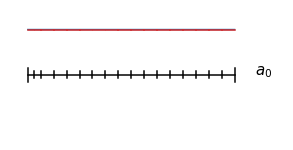

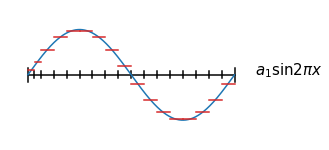

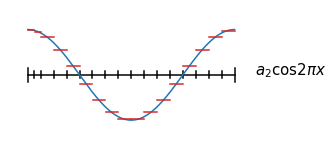

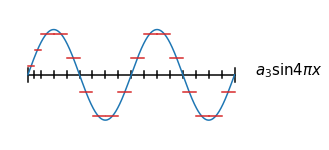

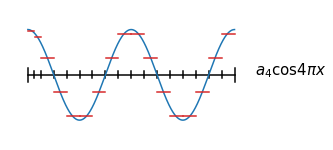

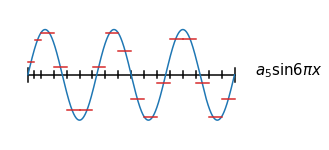

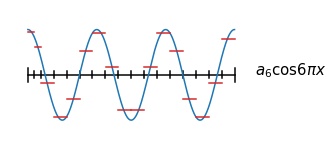

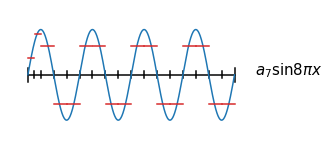

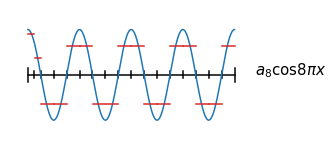

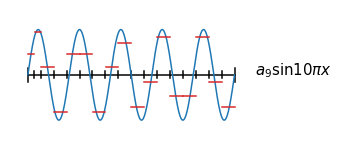

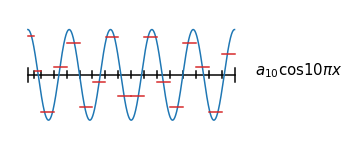

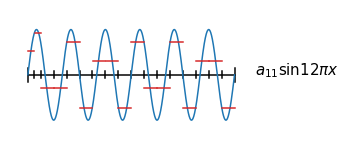

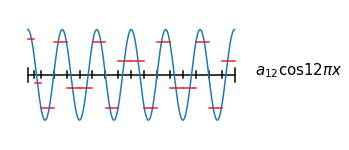

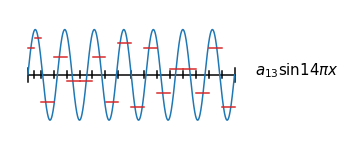

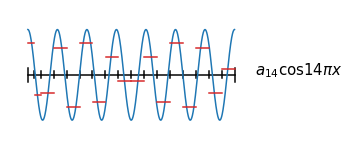

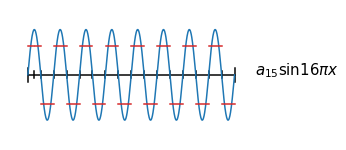

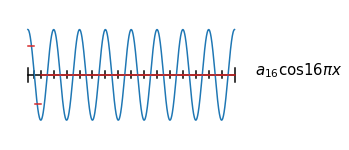

end loop i =  0


i =  1
[0, 1]
[0, 1]
False
nullspace:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

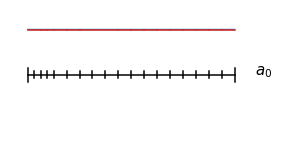

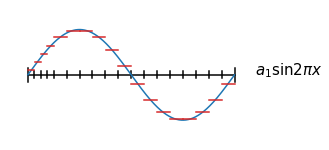

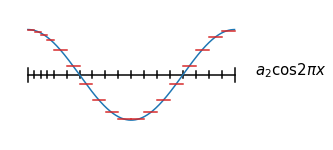

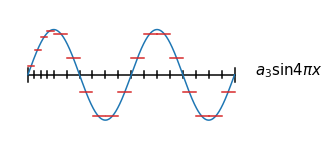

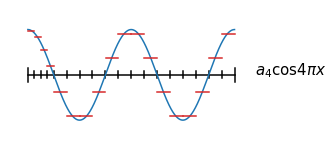

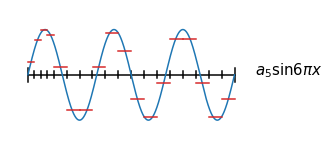

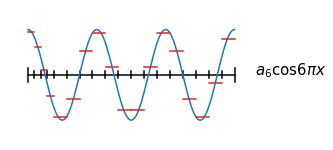

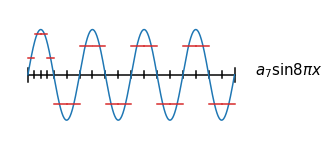

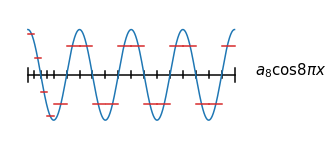

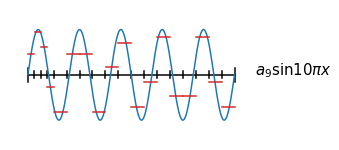

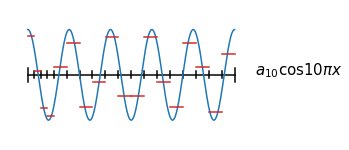

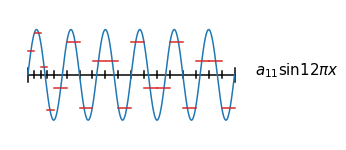

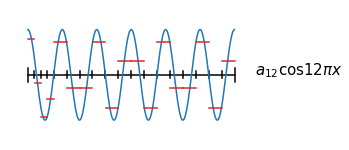

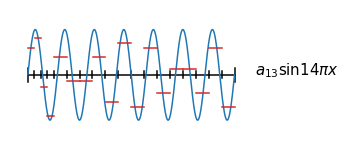

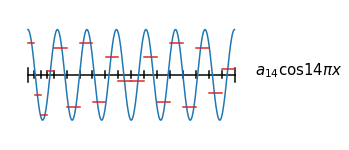

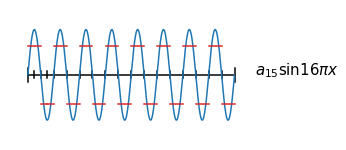

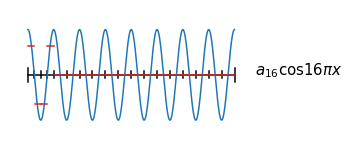

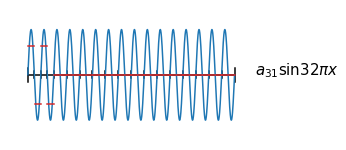

end loop i =  1


i =  2
[0, 1, 2]
[0, 1, 2]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.         

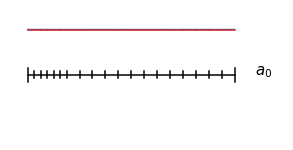

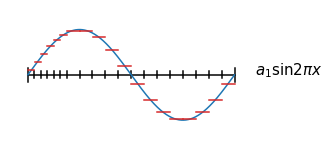

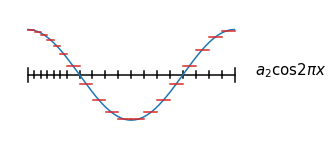

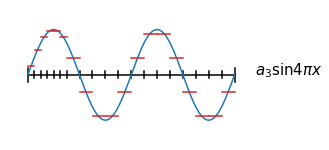

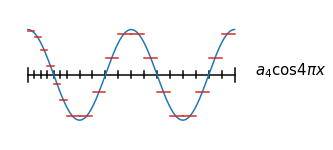

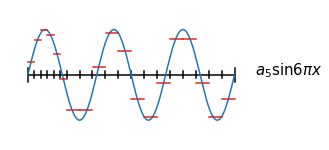

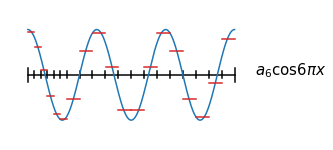

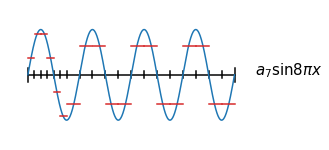

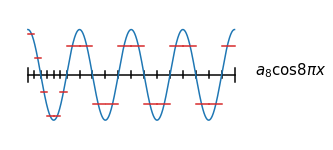

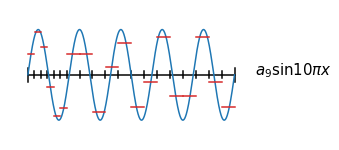

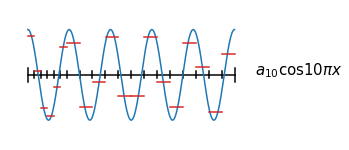

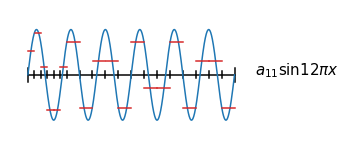

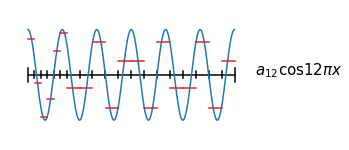

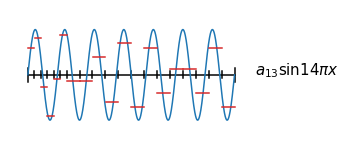

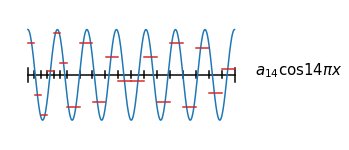

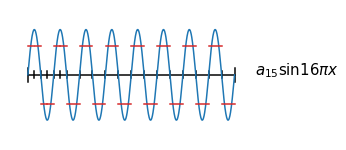

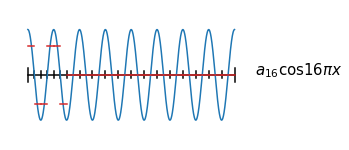

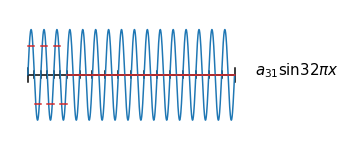

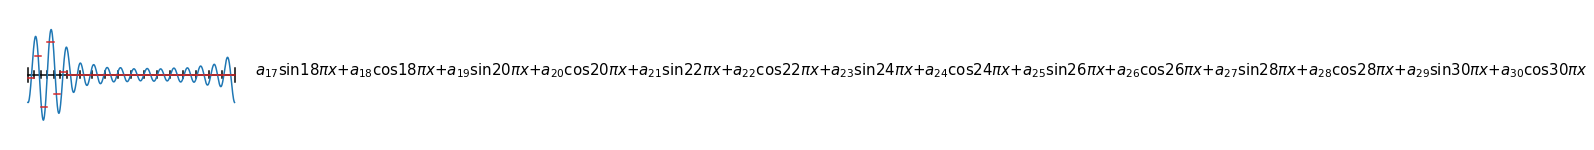

end loop i =  2


i =  3
[0, 1, 2, 3]
[0, 1, 2, 3]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.      

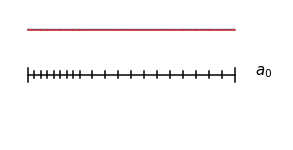

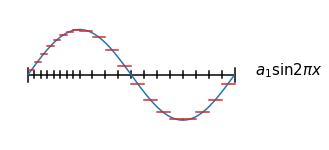

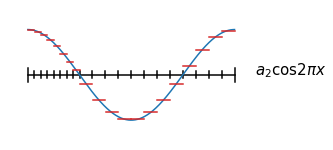

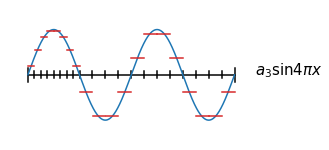

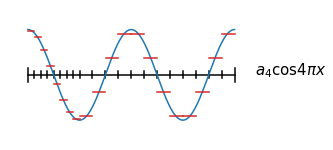

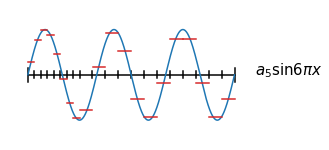

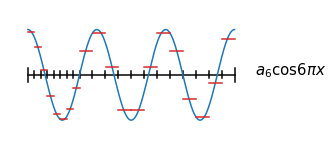

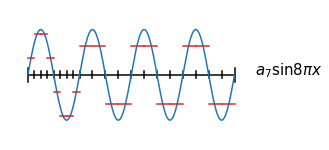

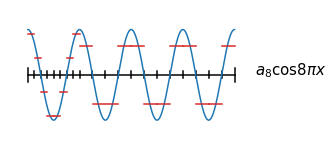

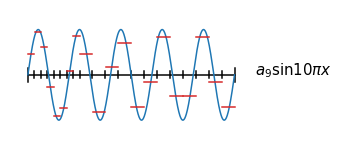

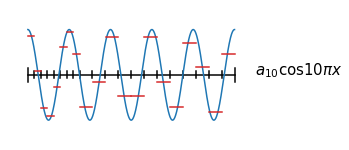

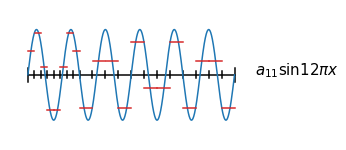

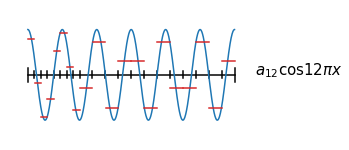

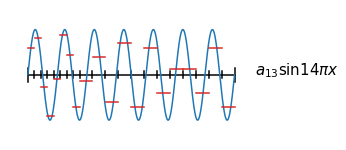

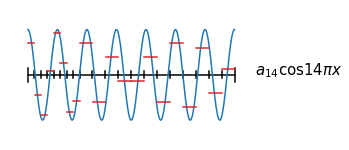

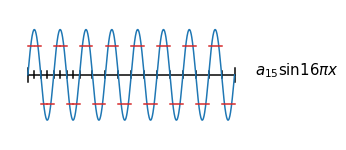

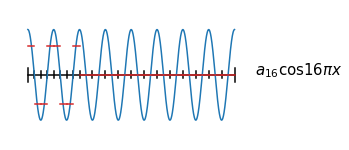

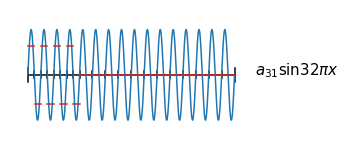

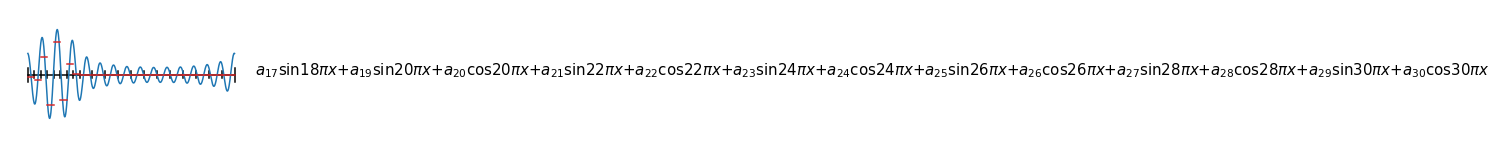

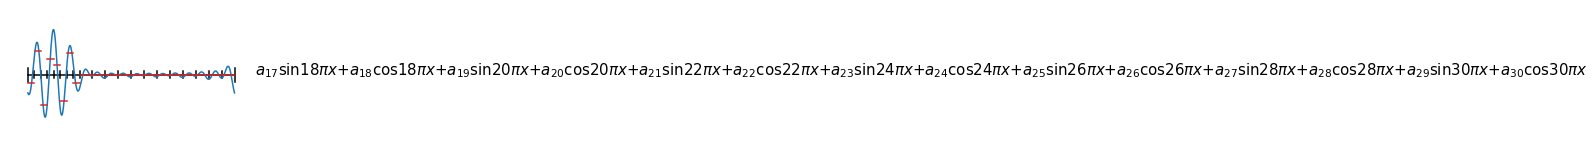

end loop i =  3


i =  4
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.

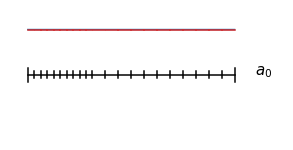

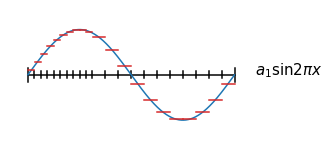

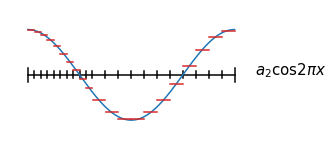

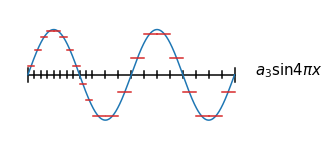

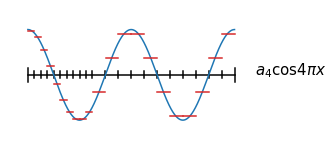

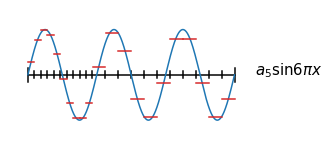

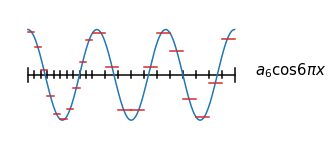

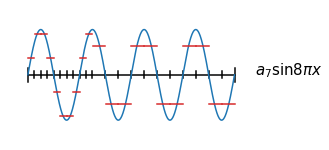

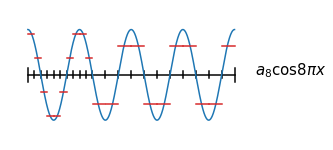

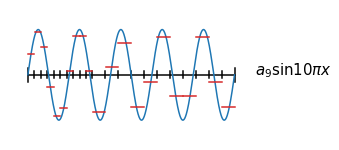

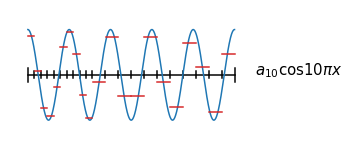

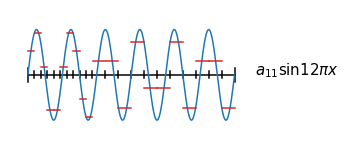

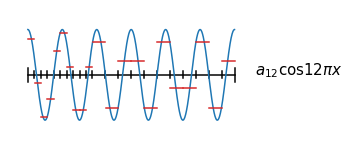

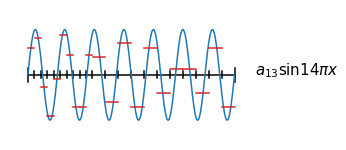

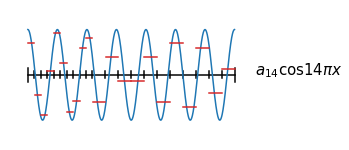

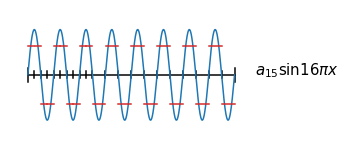

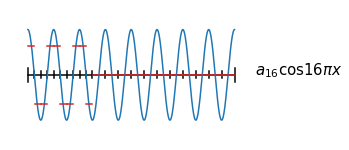

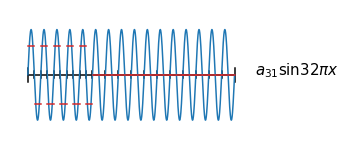

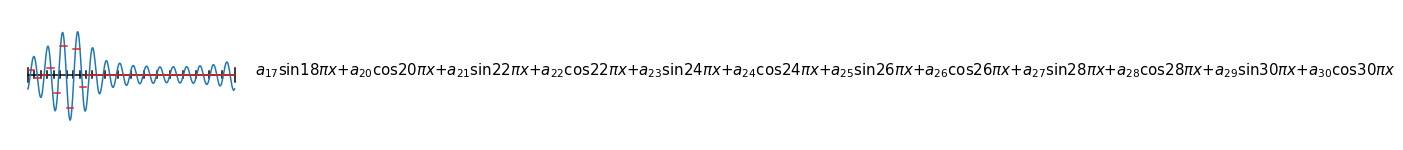

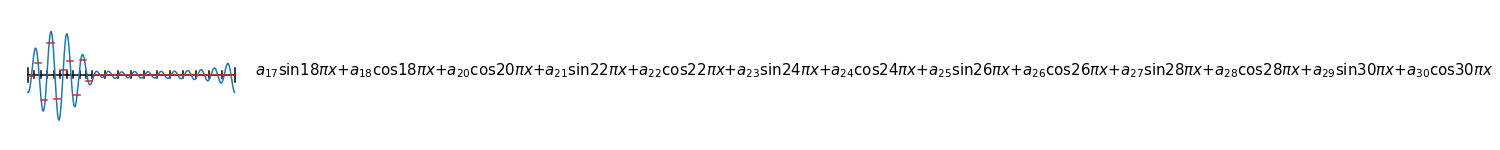

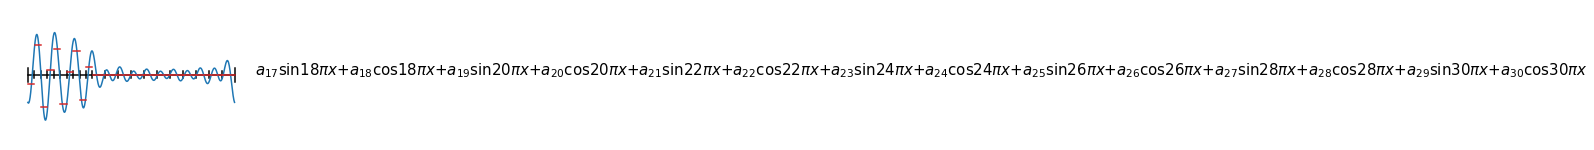

end loop i =  4


i =  5
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.      

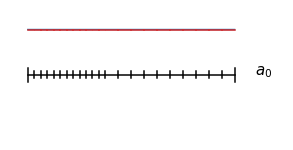

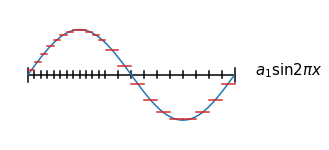

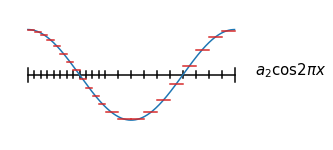

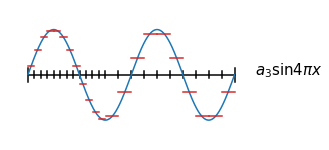

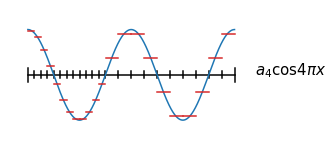

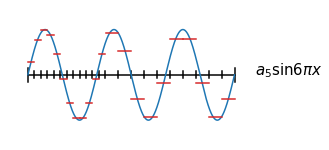

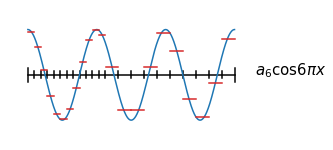

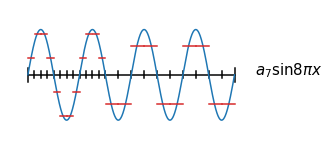

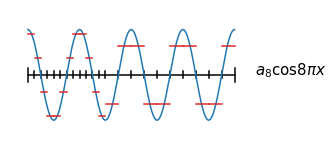

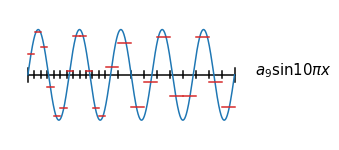

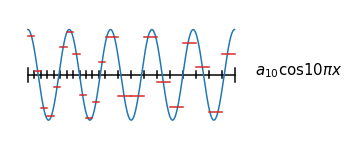

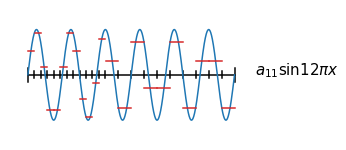

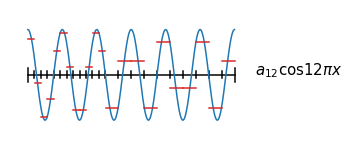

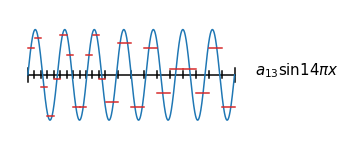

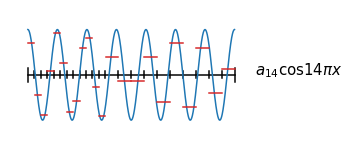

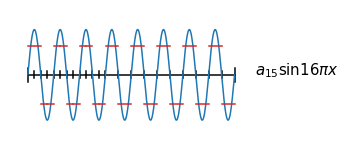

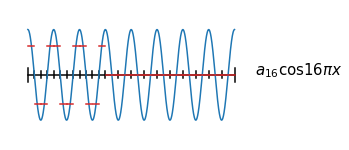

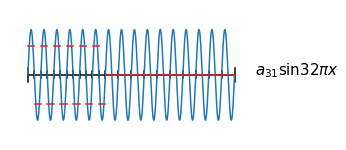

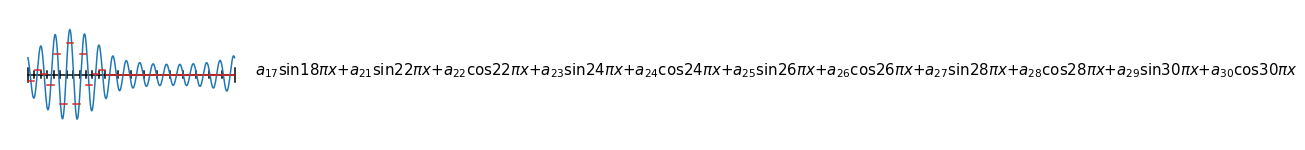

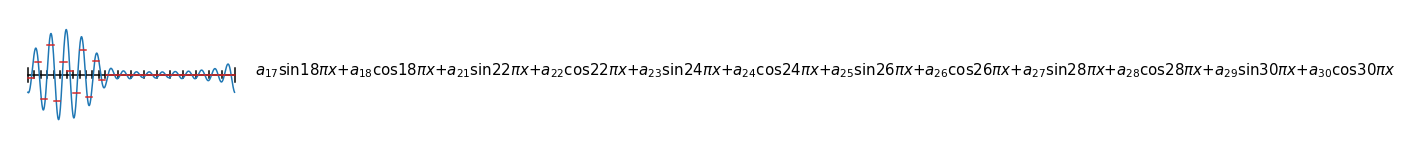

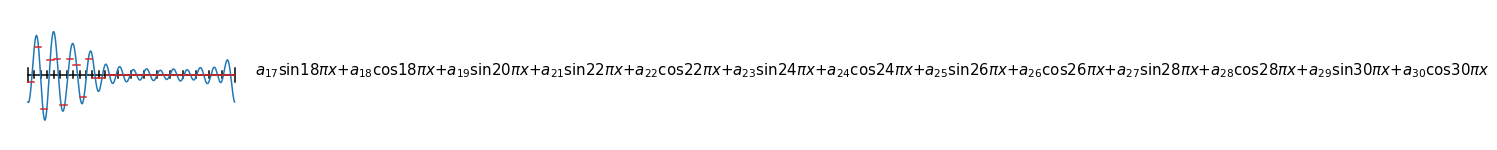

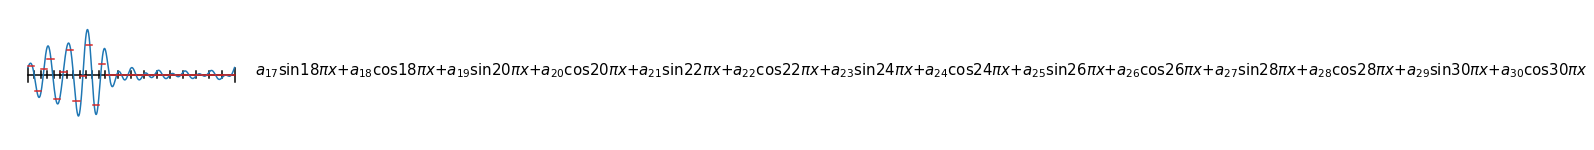

end loop i =  5


i =  6
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.

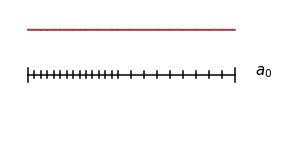

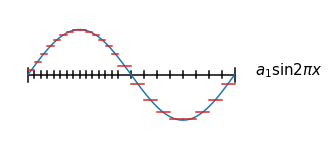

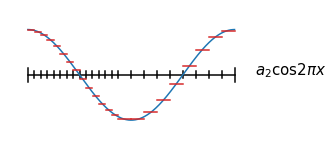

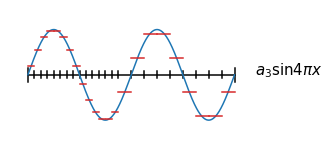

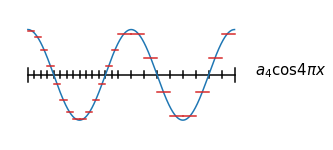

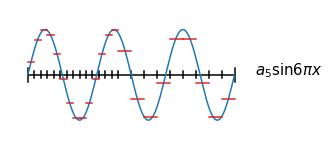

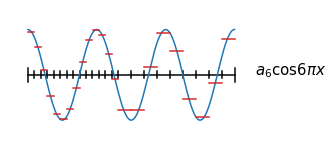

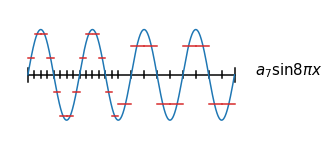

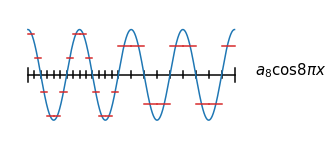

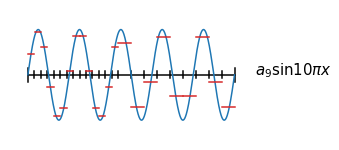

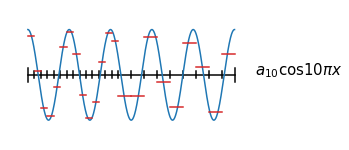

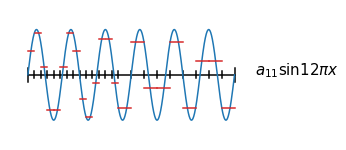

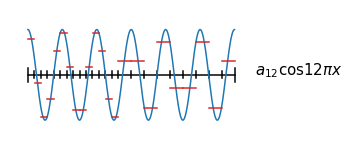

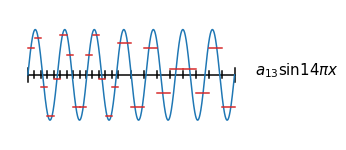

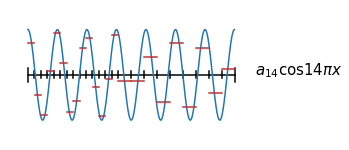

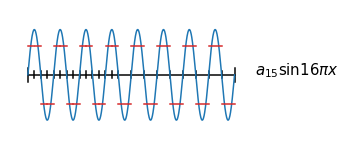

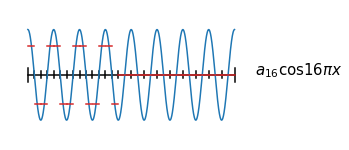

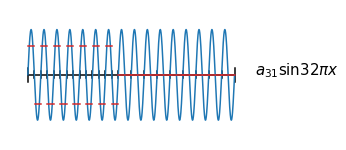

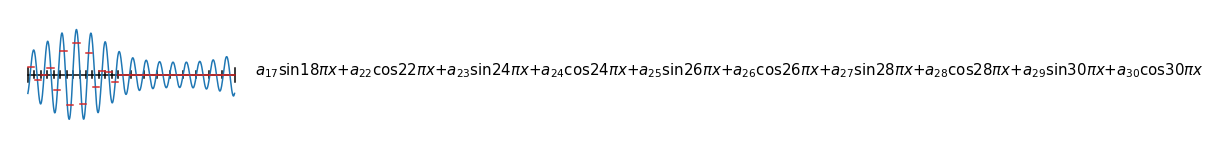

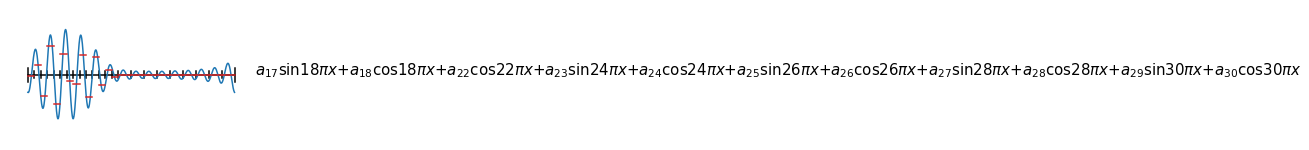

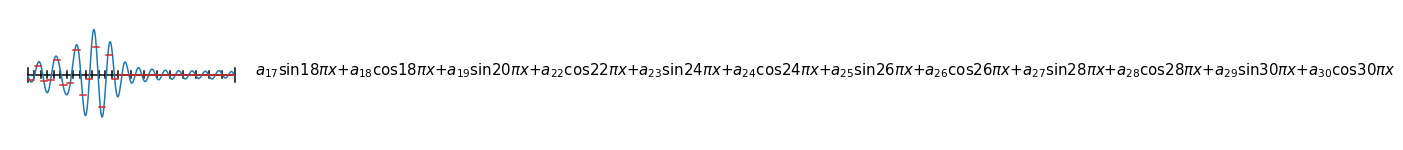

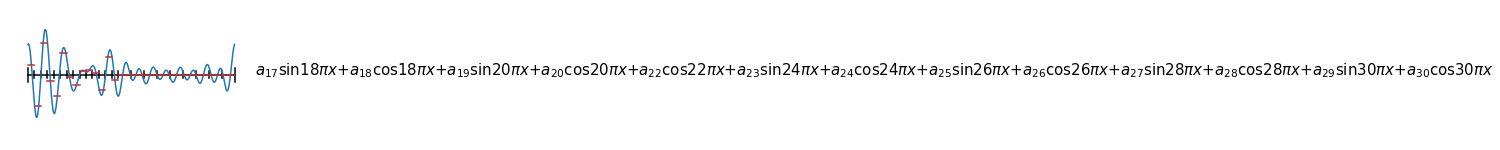

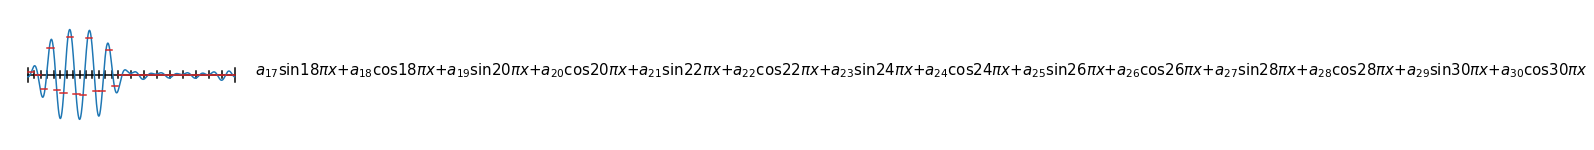

end loop i =  6


i =  7
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7]
False
nullspace:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0

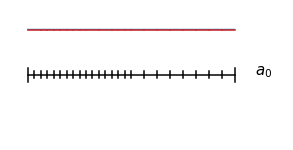

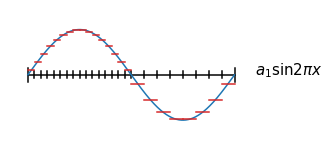

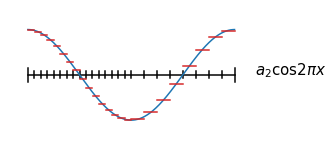

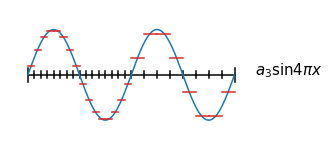

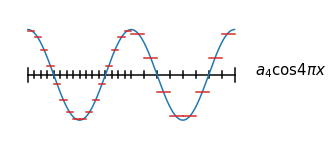

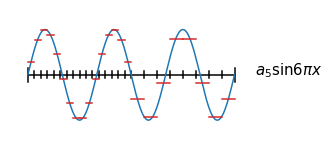

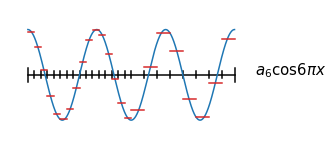

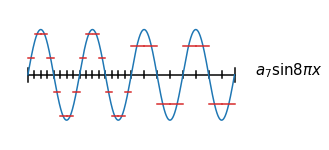

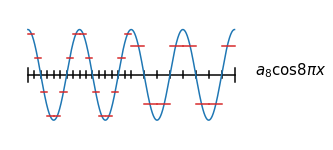

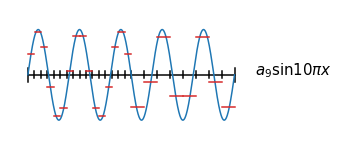

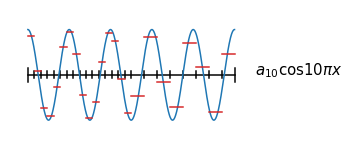

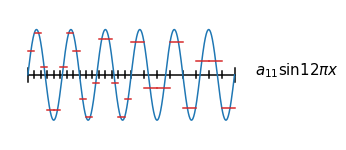

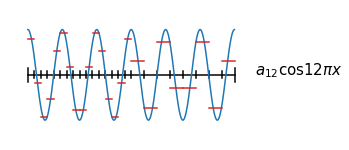

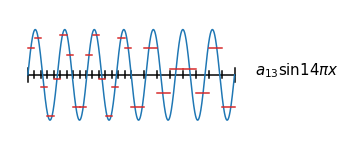

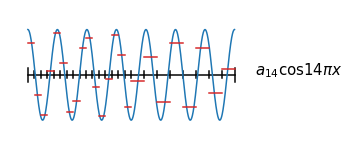

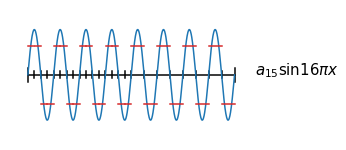

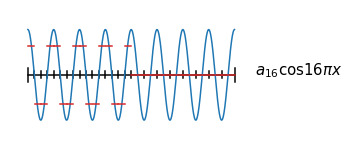

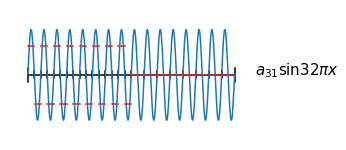

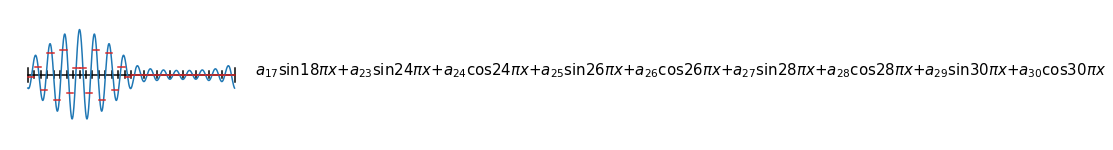

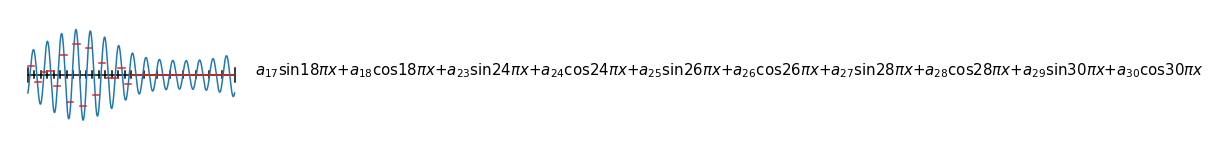

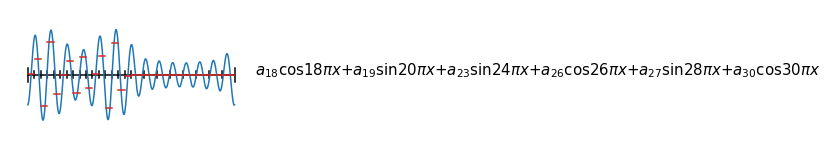

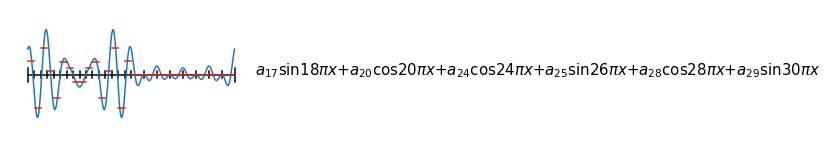

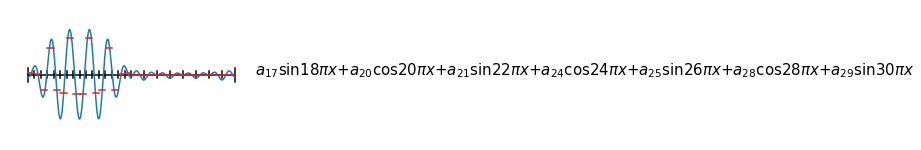

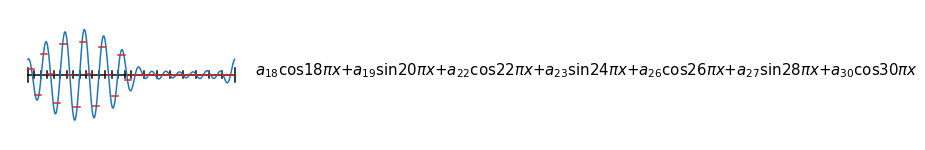

end loop i =  7


i =  8
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
False
nullspace:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+0

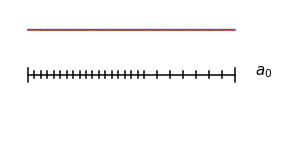

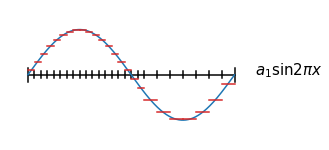

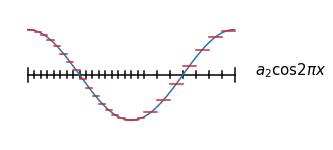

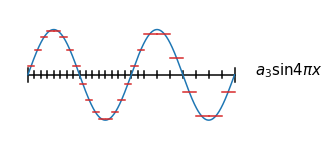

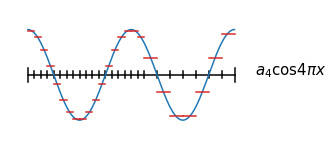

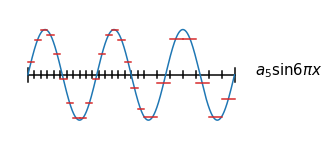

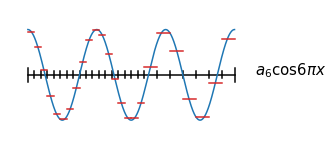

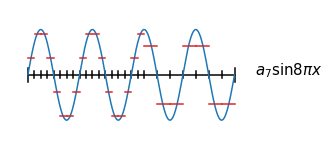

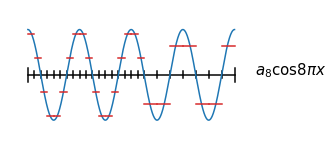

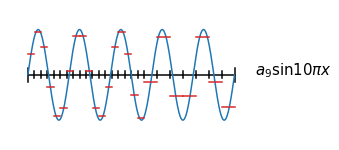

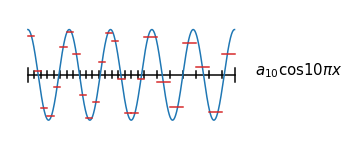

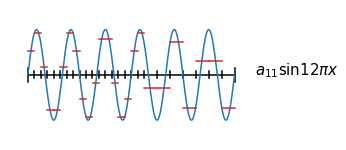

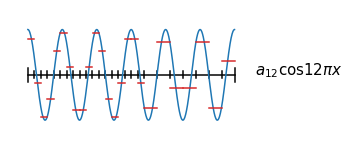

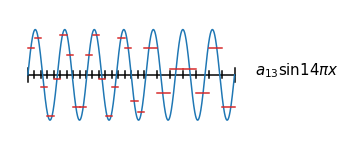

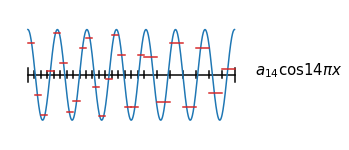

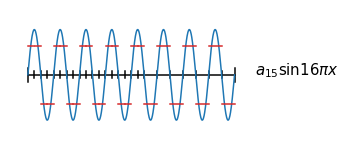

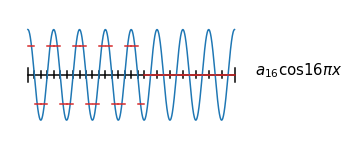

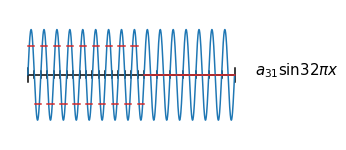

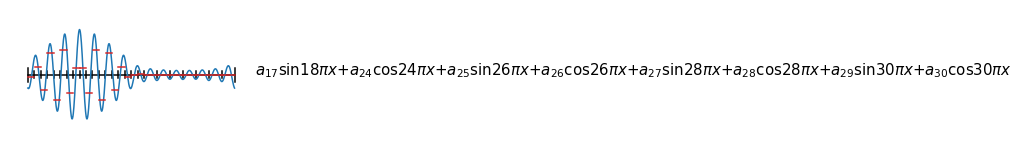

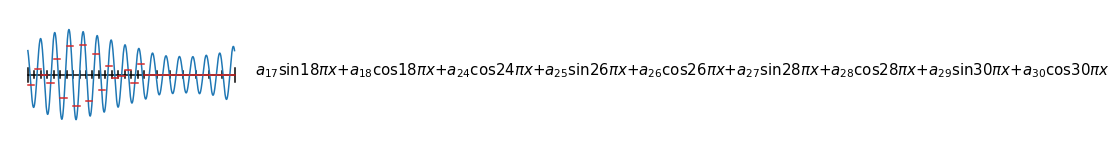

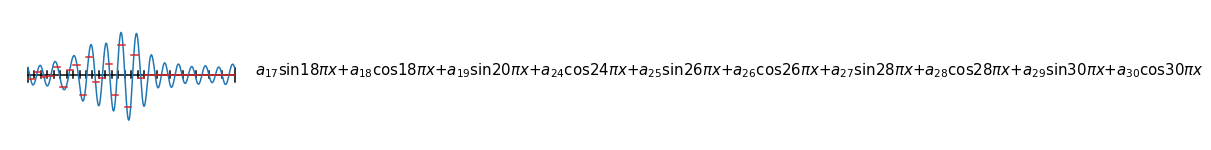

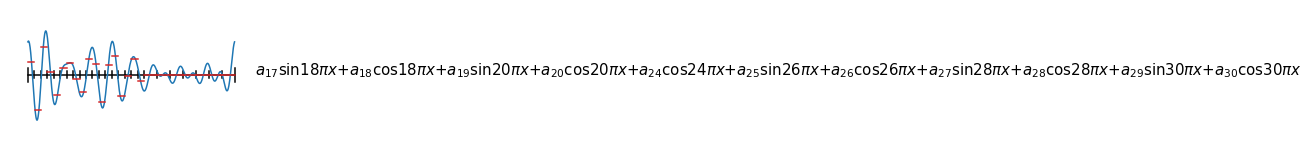

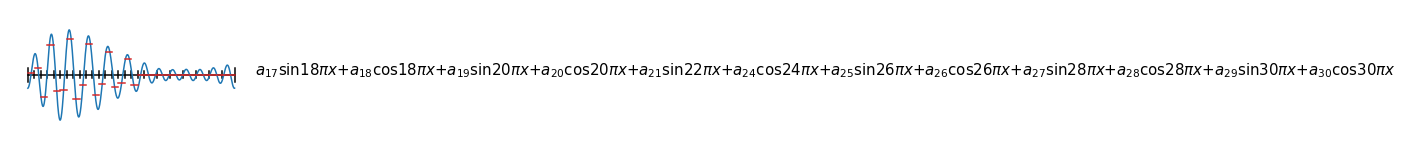

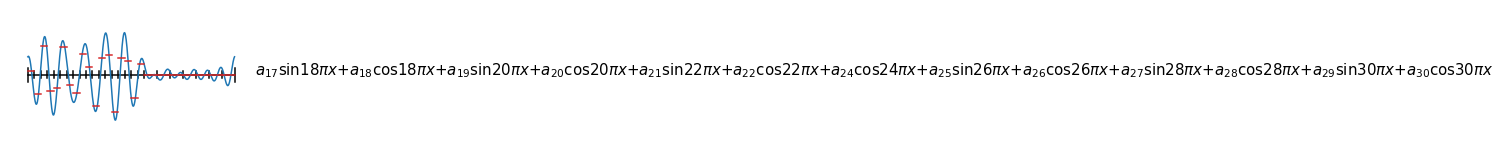

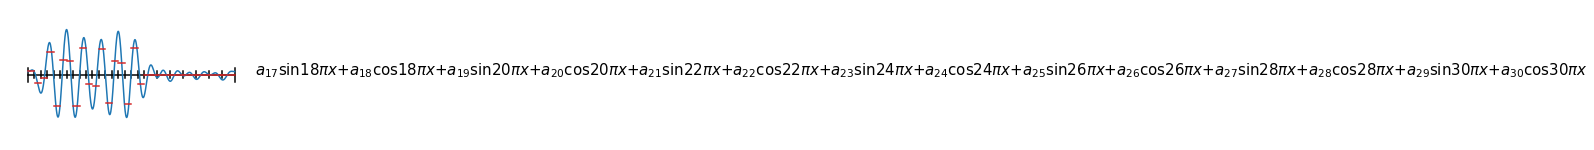

end loop i =  8


i =  9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.         


AMR:

FCoefsExact:
[ 1.00548547e-32  1.33864909e-34  4.32389898e-33  2.35727841e-32 -2.13460436e-34  2.84502788e-32 -2.01715355e-32 -1.03023328e-31  1.88406941e-32 -1.64096804e-32  3.12216266e-33 -1.09175104e-31  1.72819210e-33 -7.19681410e-32  5.68352866e-32 -2.33125161e-32  3.00101371e-32 -9.25194656e-32  8.15590436e-32  8.65891800e-32  3.84824489e-32 -5.25503640e-32 -1.78765181e-32  1.03767818e-32  8.00770214e-32 -8.37488629e-35  6.18433634e-32 -1.18379944e-32  2.97994095e-31  3.61916520e-33  1.00000000e+00 -2.42774839e-33]
nullspace @ FCoefsTest:
[-2.50295562e-17 -8.46634504e-17 -2.13792949e-02  3.05943249e-02 -2.25766969e-03  3.93714534e-03  1.67800057e-02  1.02922964e-02 -4.94253504e-03  1.69382043e-02  1.99799743e-02 -1.32480381e-03  1.98270901e-03  4.73463564e-02  1.45146394e-02 -1.22872405e-16  8.46917945e-02 -6.08738868e-02  1.86616792e-02  2.20800635e-03  3.30451502e-03 -3.72640496e-02  4.39559435e-02 -3.08768893e-02 -1.48276051e-02 -1.70609632e-02  7.27133580e-02 -2.141602

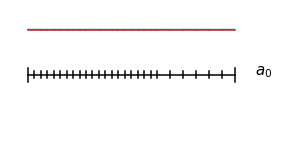

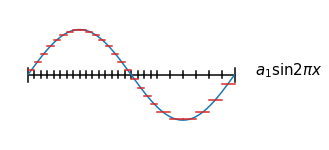

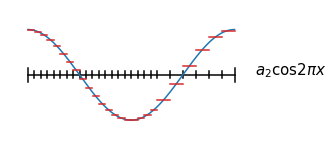

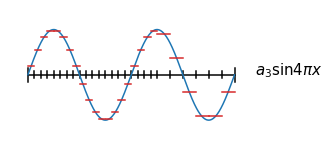

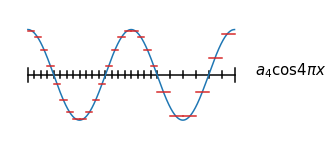

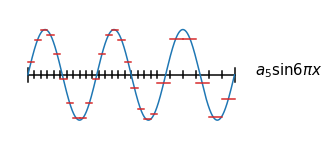

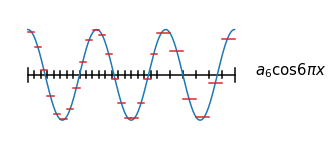

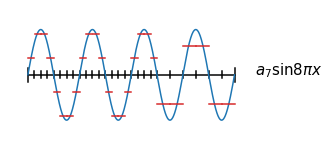

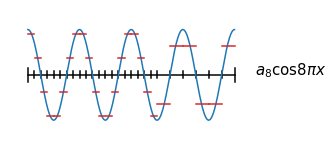

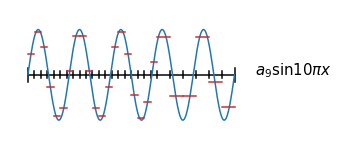

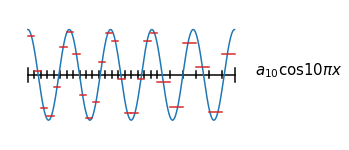

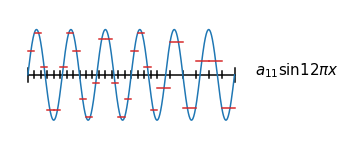

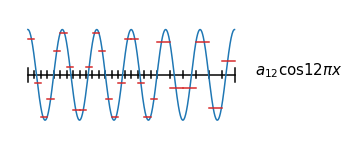

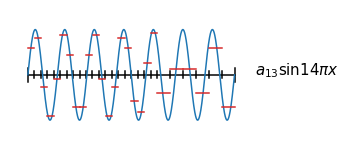

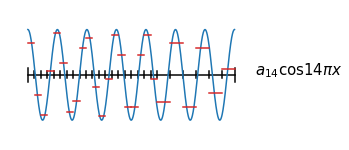

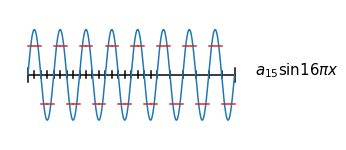

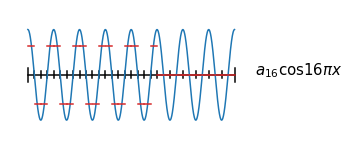

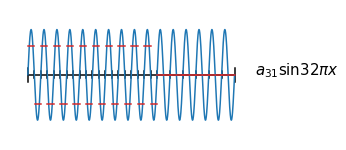

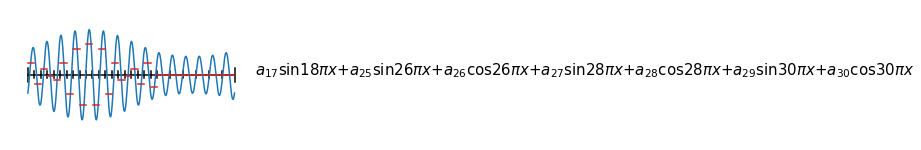

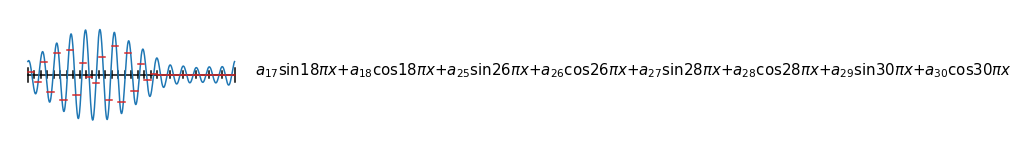

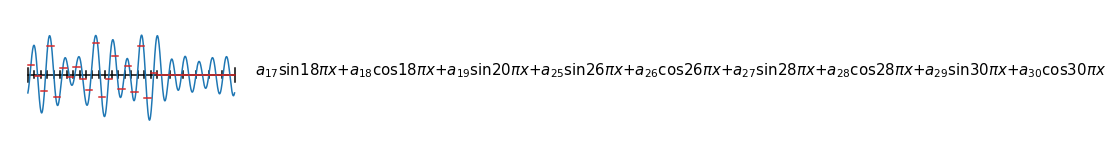

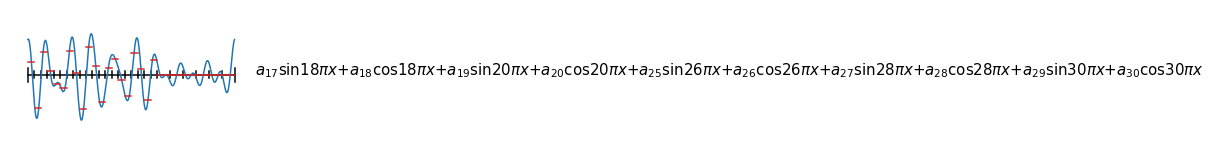

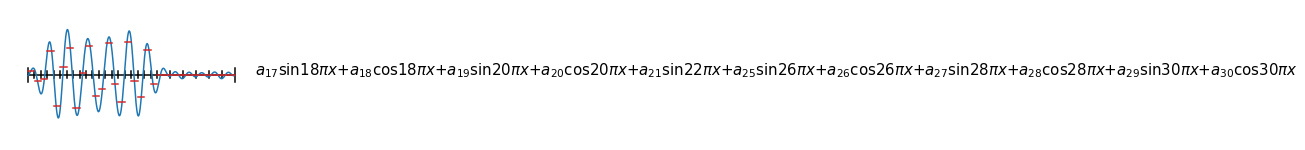

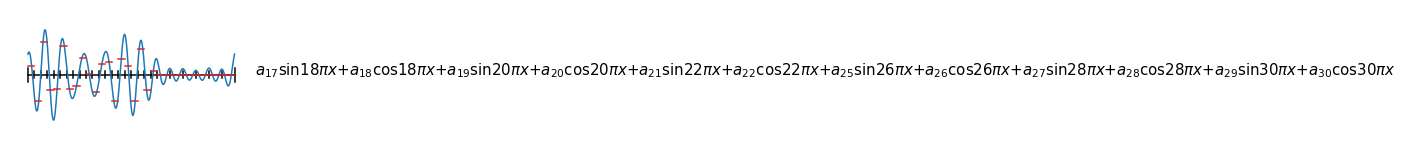

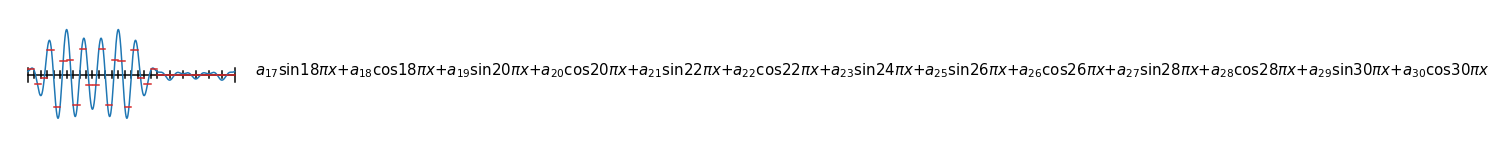

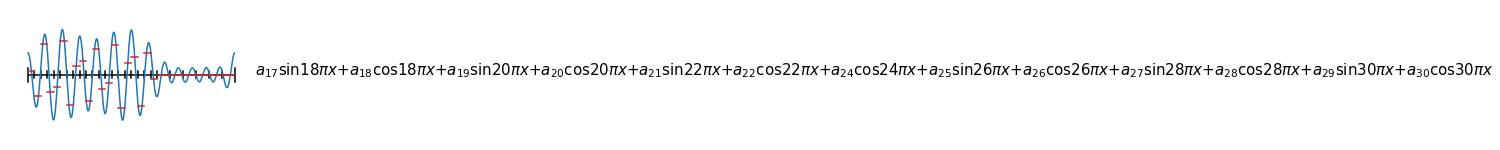

end loop i =  9


i =  10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.

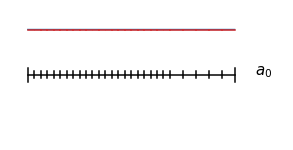

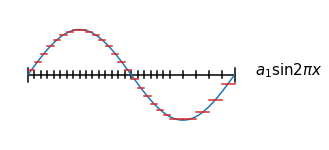

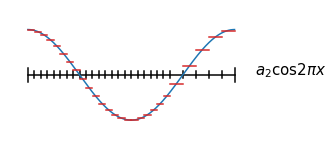

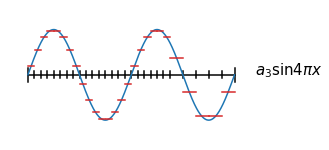

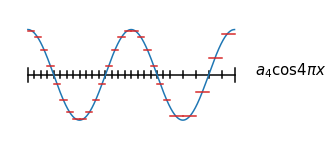

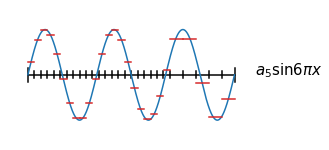

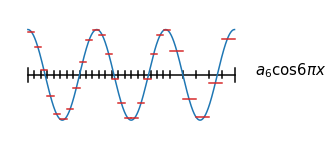

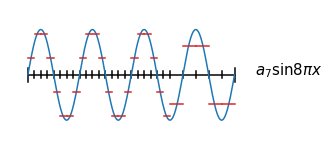

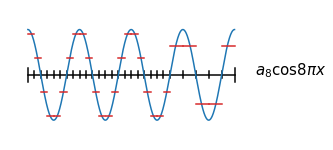

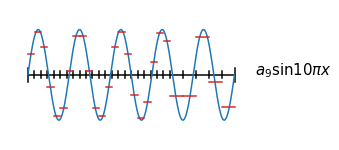

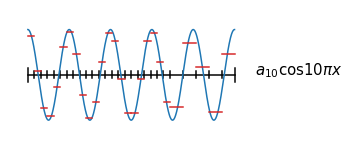

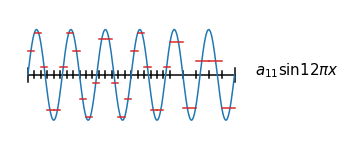

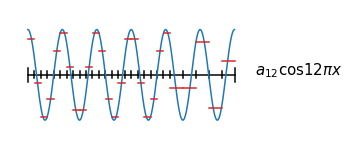

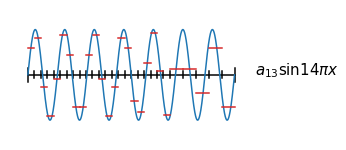

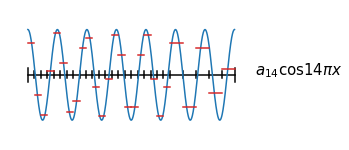

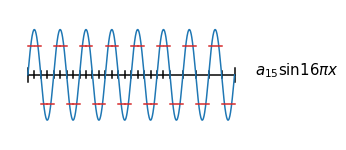

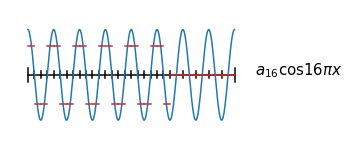

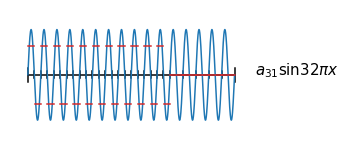

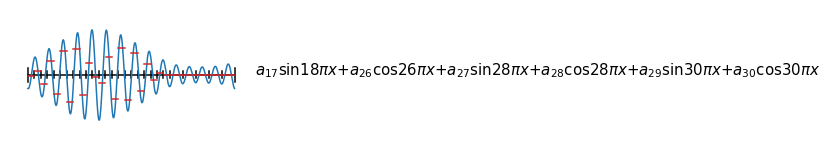

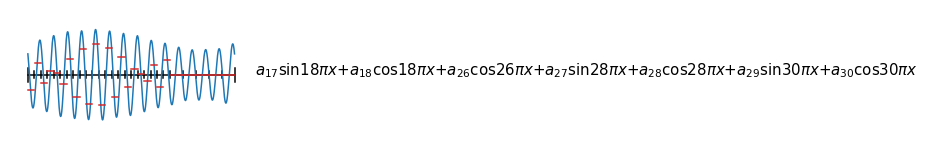

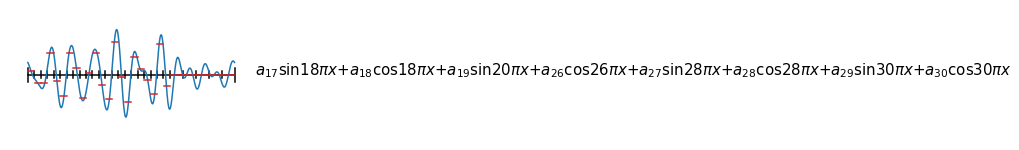

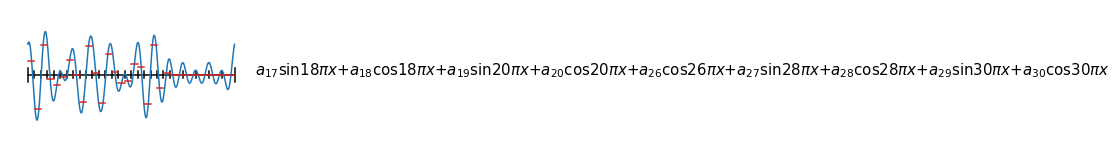

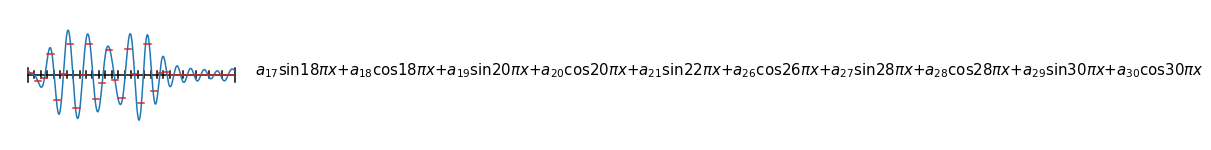

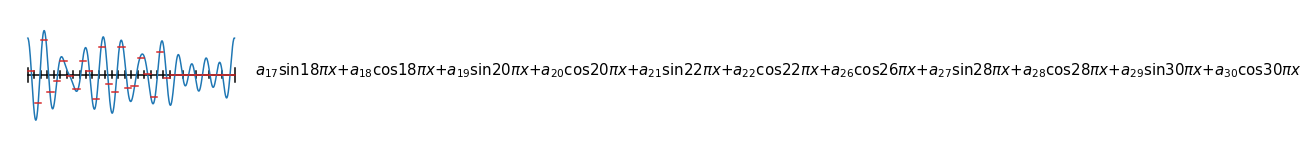

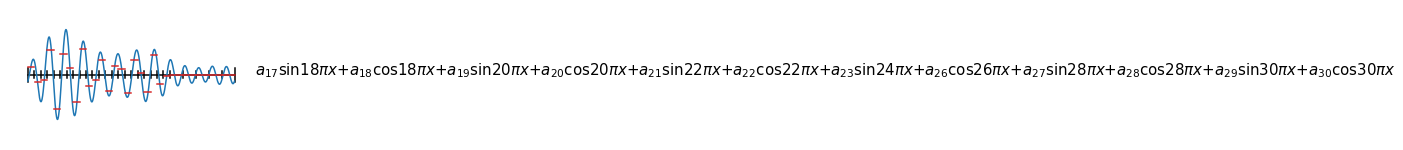

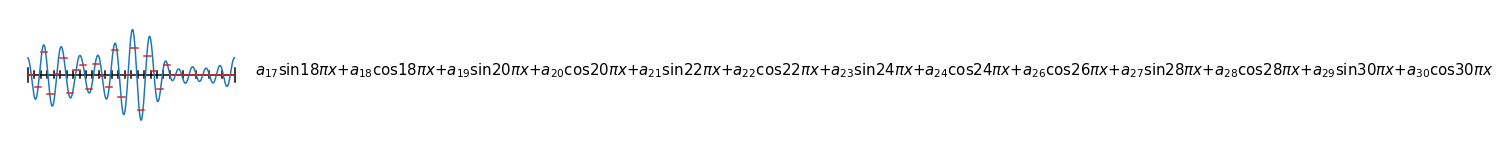

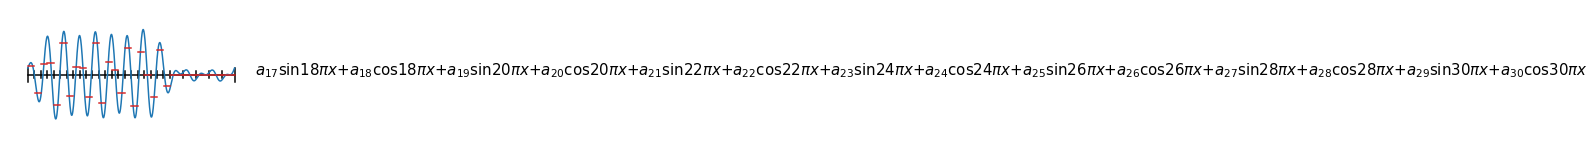

end loop i =  10


i =  11
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
False
nullspace:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

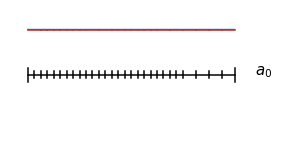

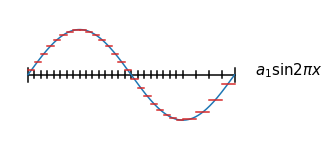

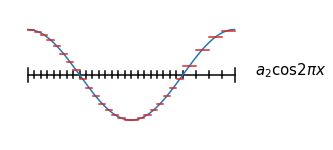

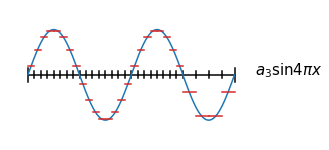

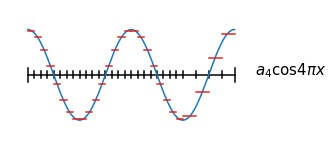

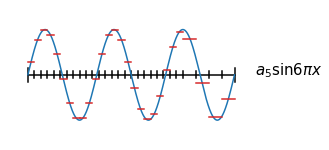

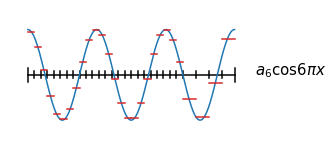

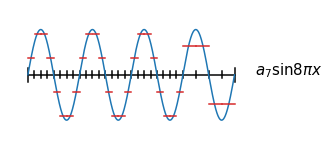

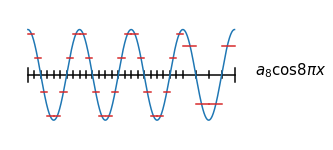

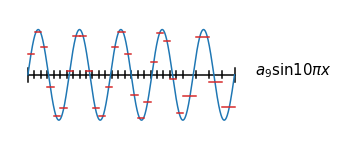

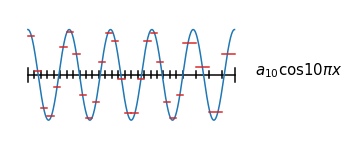

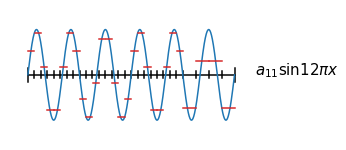

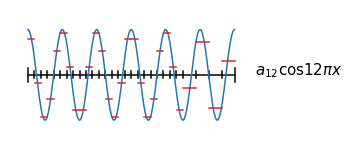

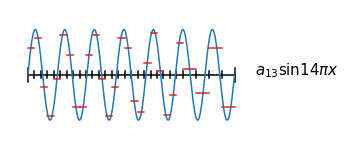

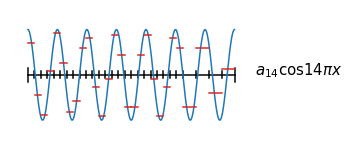

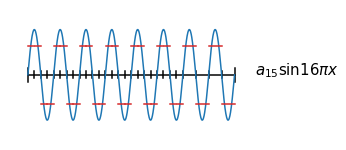

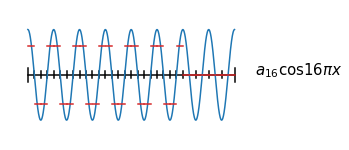

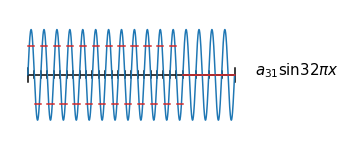

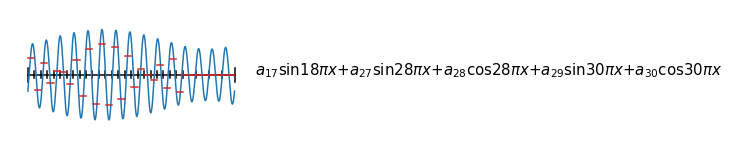

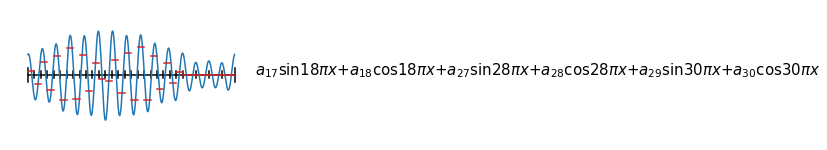

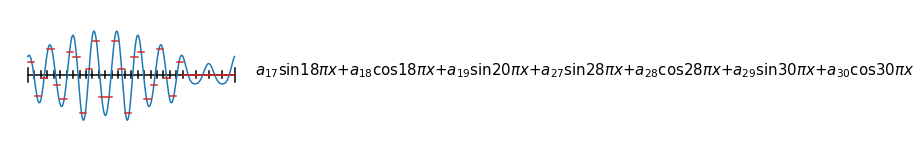

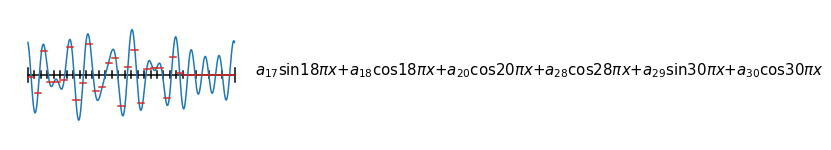

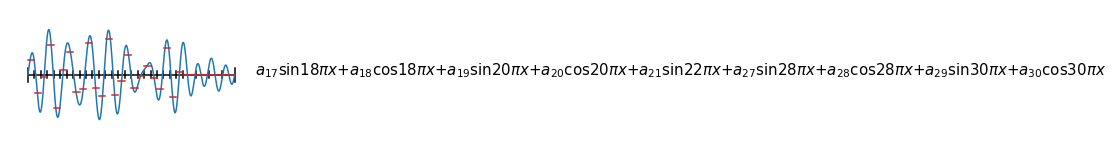

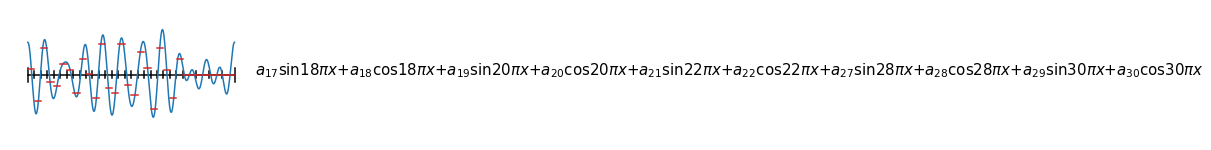

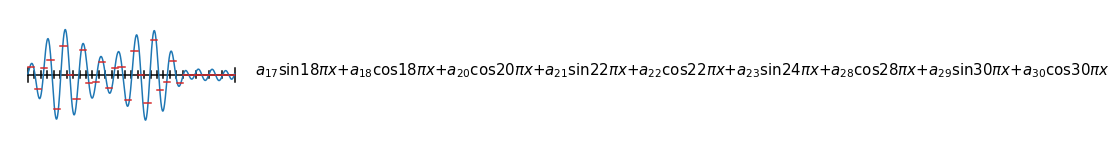

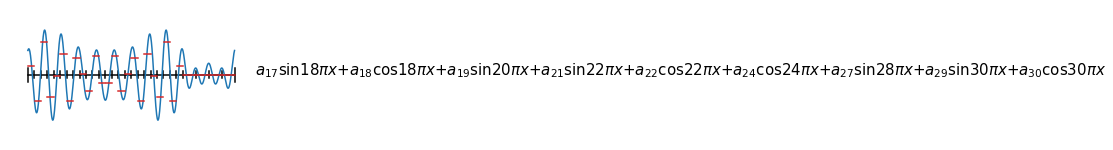

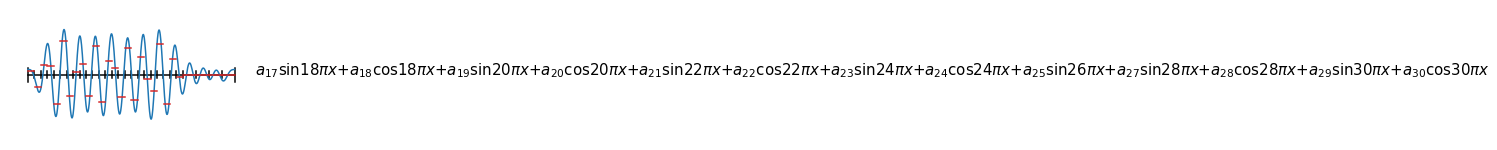

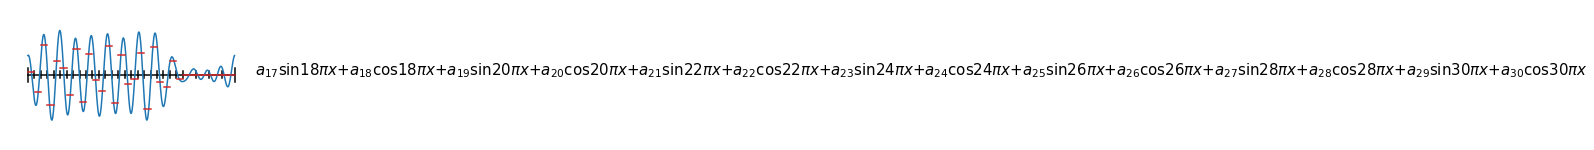

end loop i =  11


i =  12
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
False
nullspace:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  

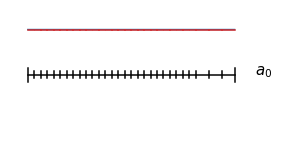

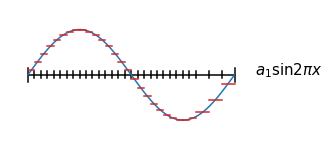

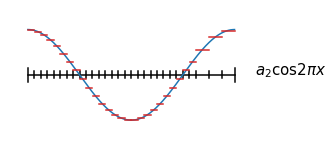

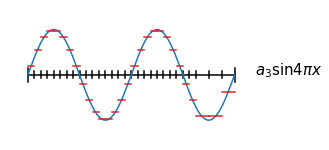

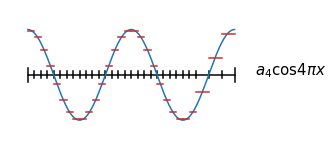

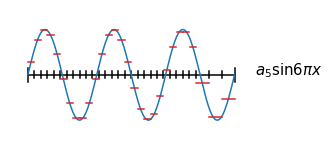

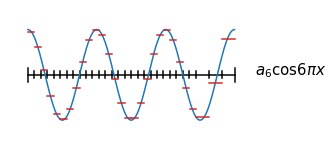

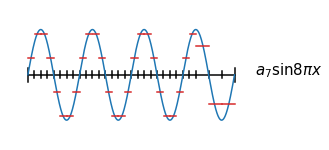

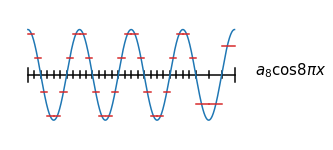

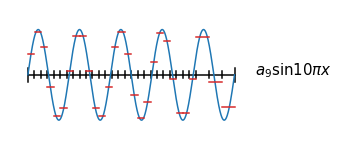

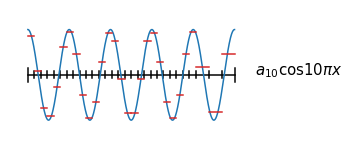

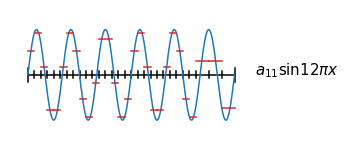

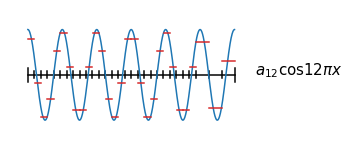

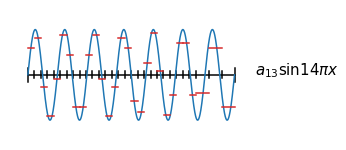

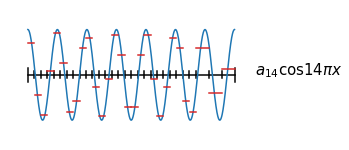

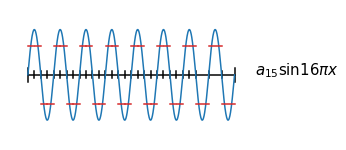

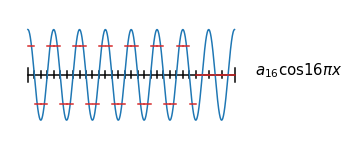

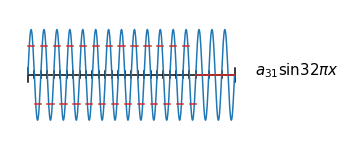

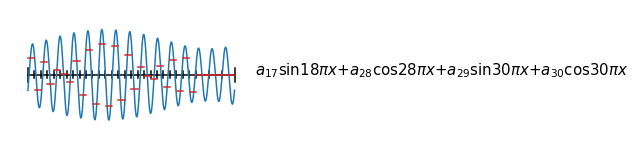

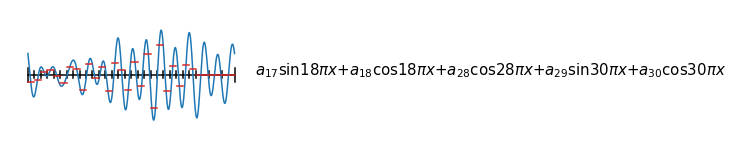

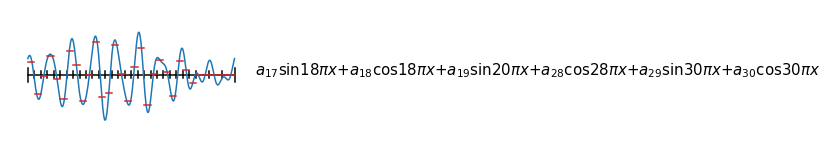

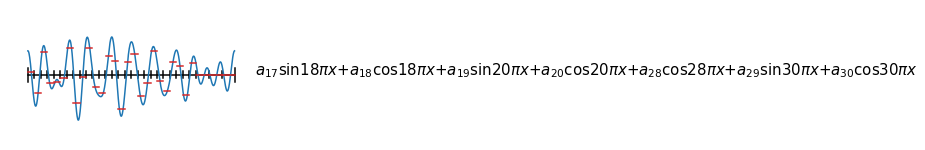

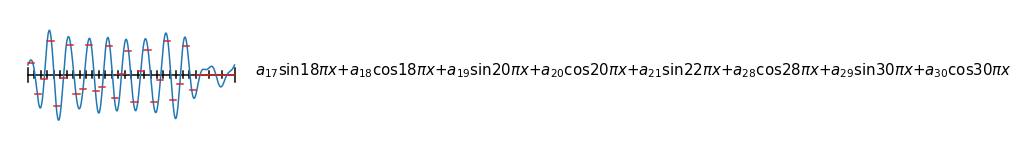

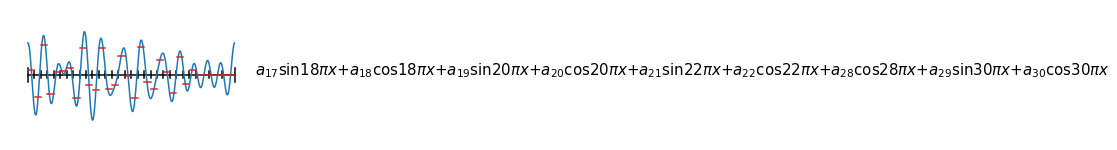

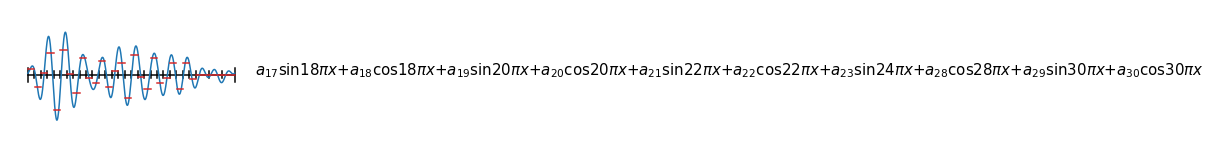

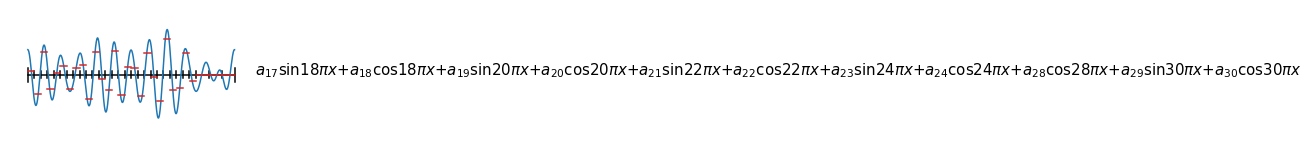

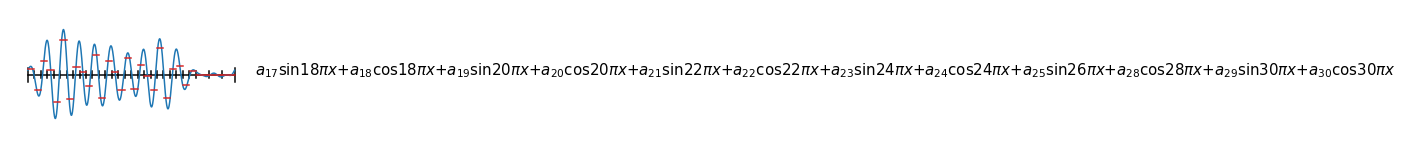

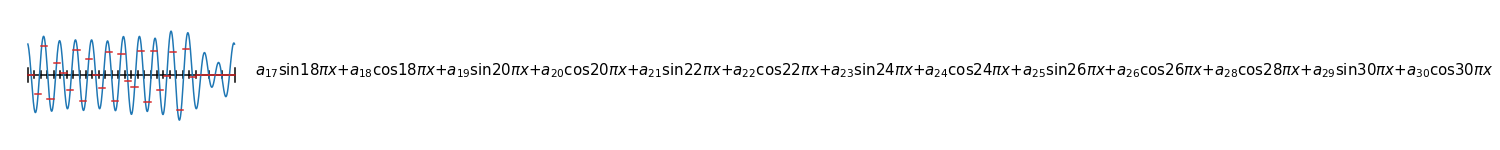

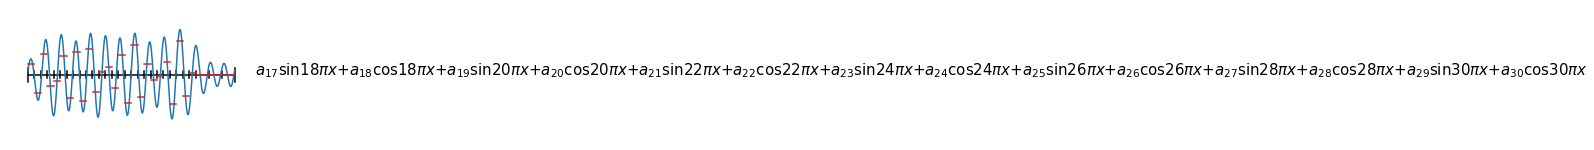

end loop i =  12


i =  13
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
False
nullspace:
[[ 1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0

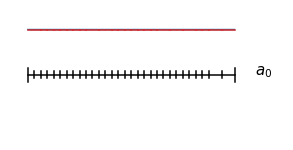

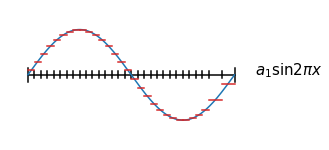

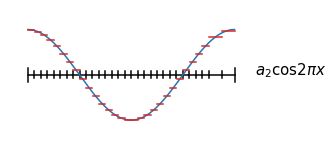

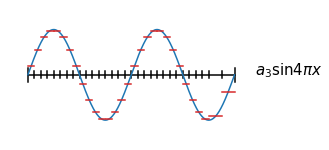

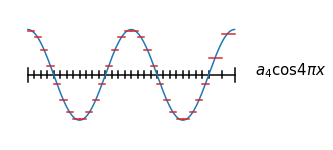

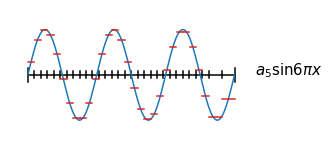

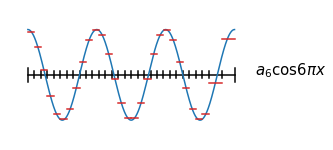

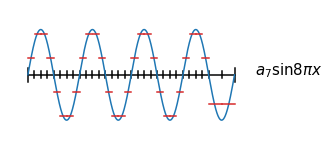

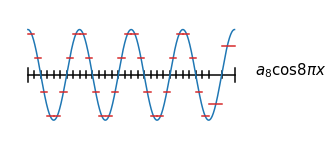

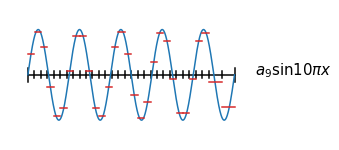

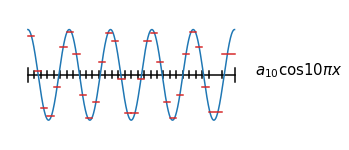

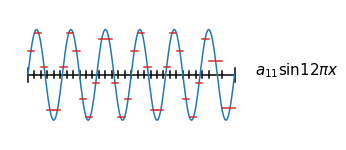

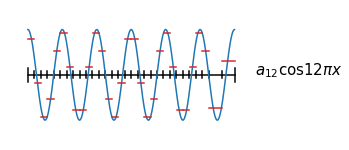

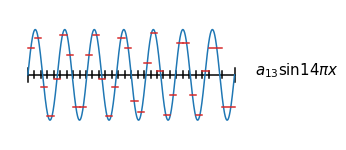

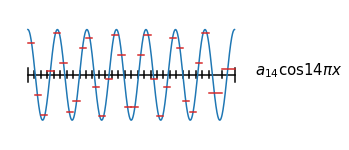

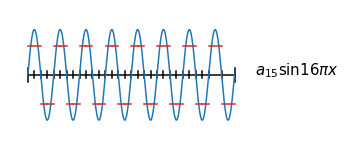

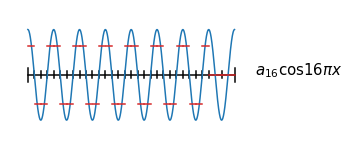

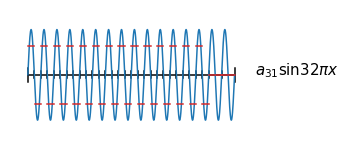

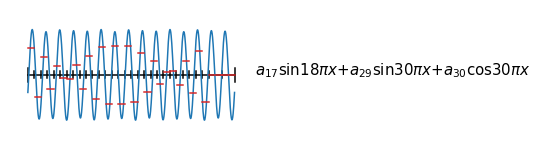

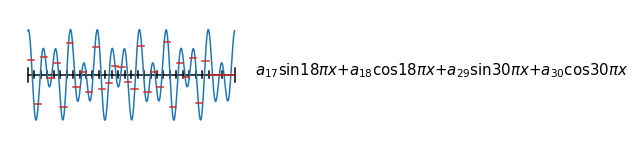

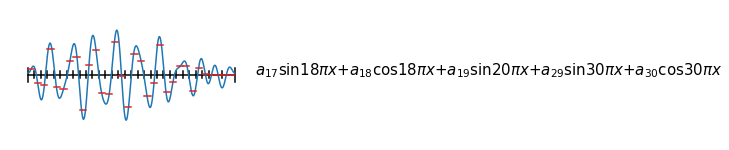

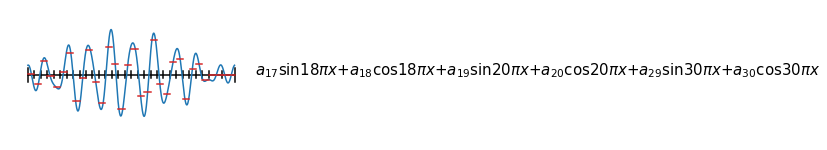

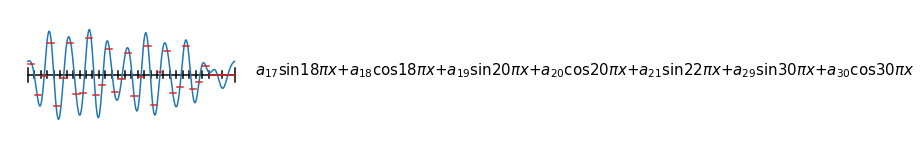

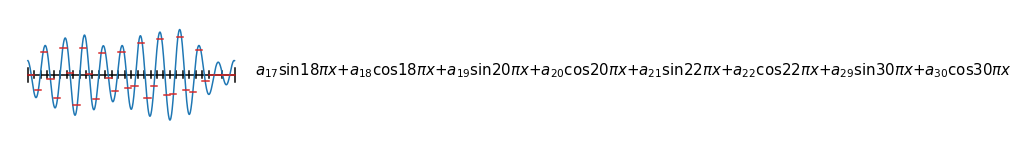

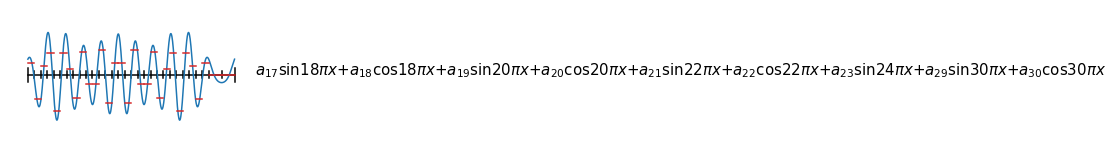

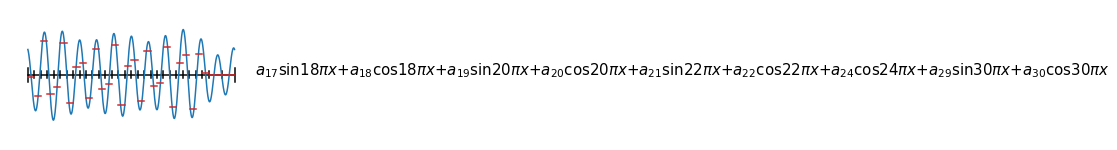

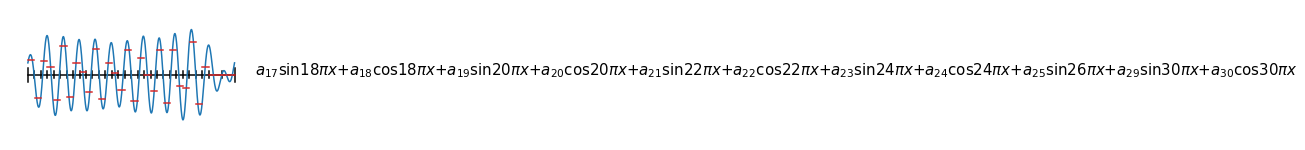

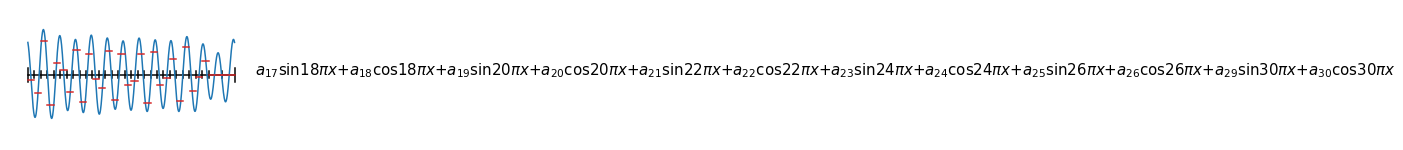

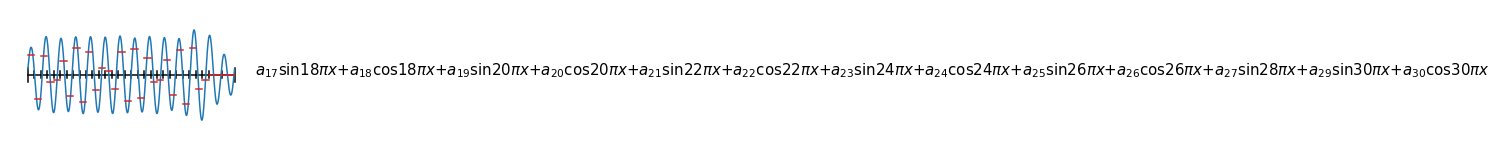

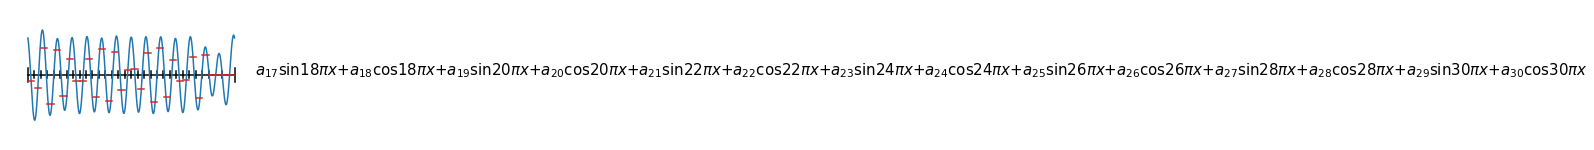

end loop i =  13


i =  14
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
False
nullspace:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  

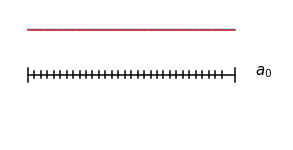

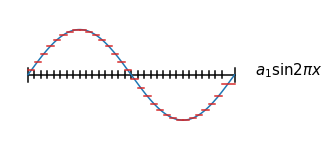

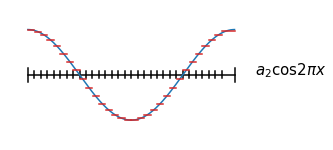

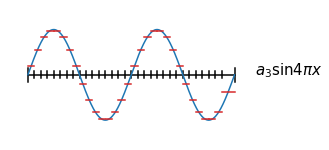

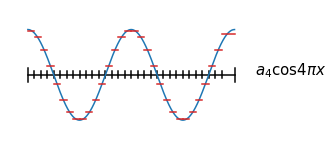

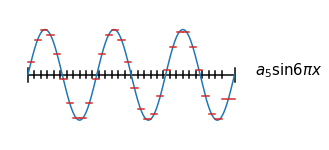

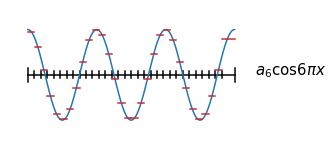

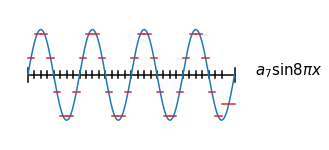

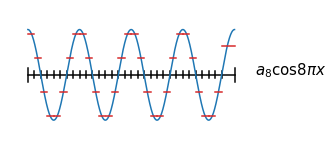

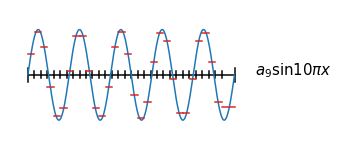

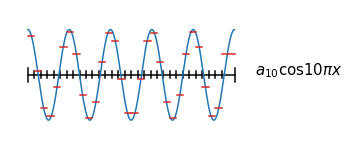

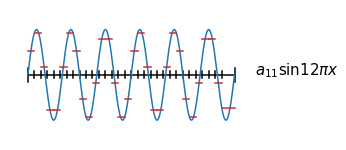

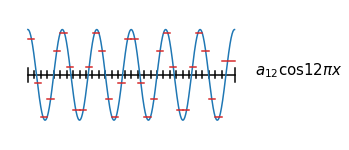

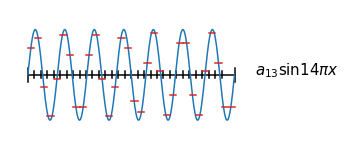

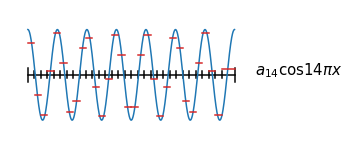

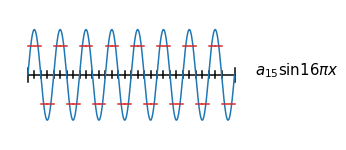

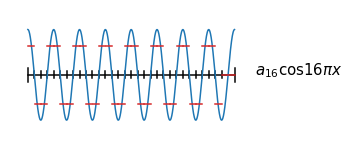

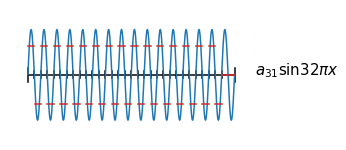

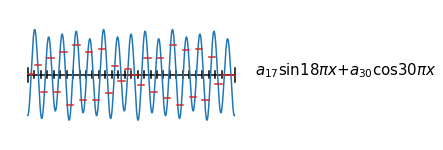

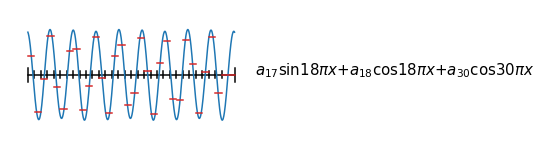

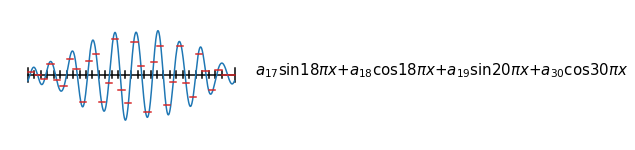

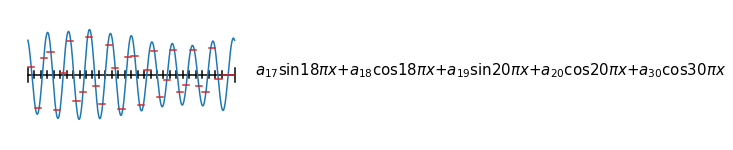

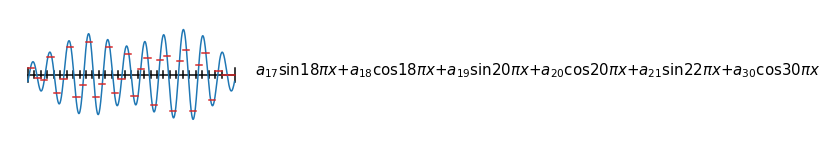

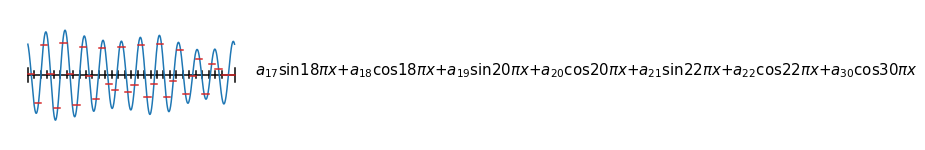

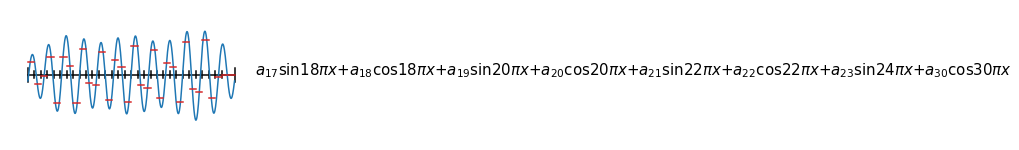

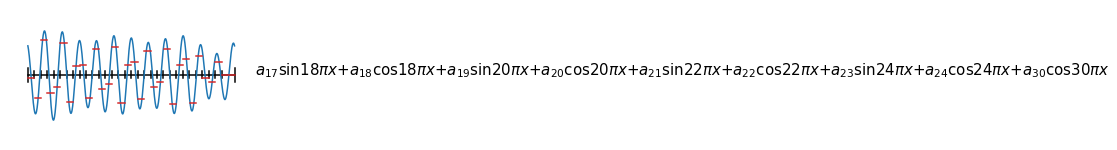

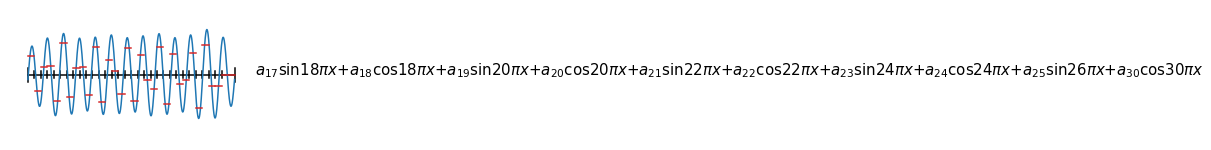

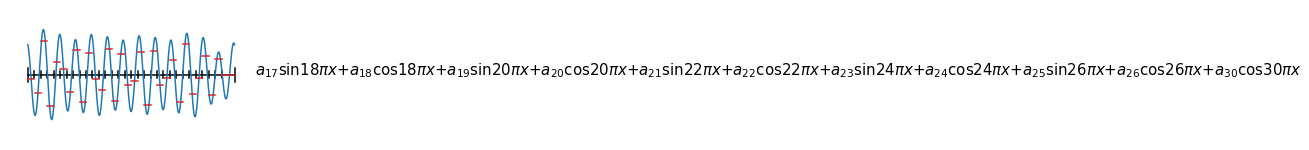

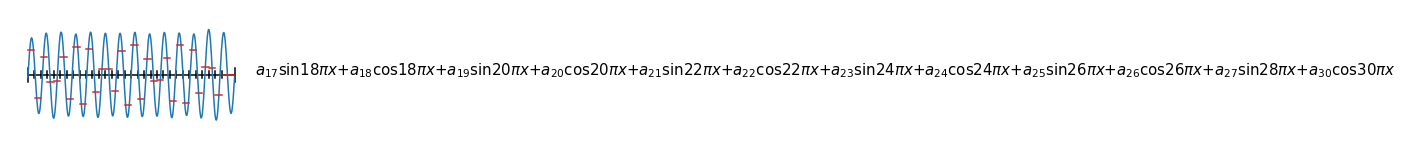

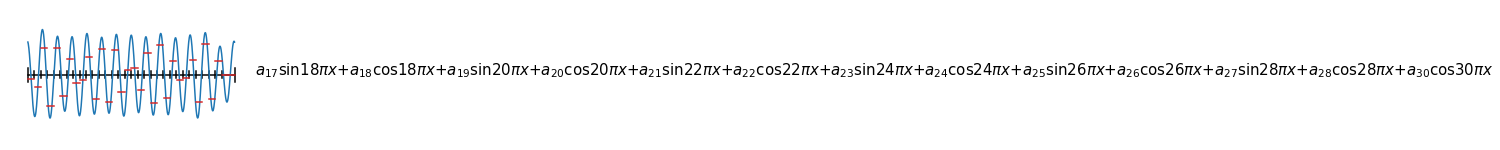

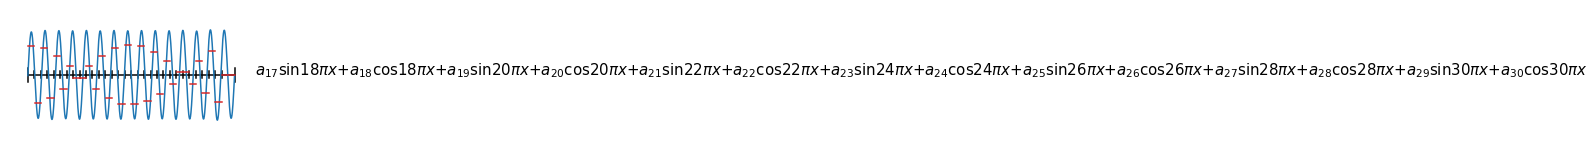

end loop i =  14


i =  15
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
True
nullspace:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.

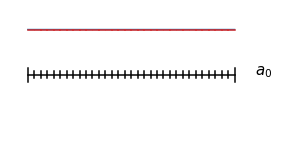

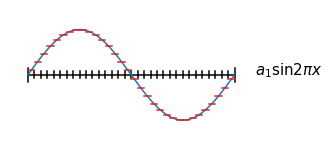

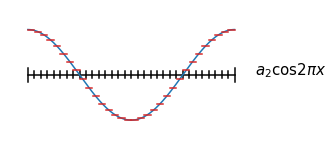

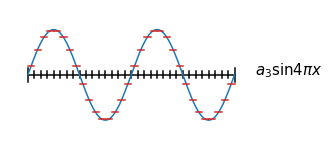

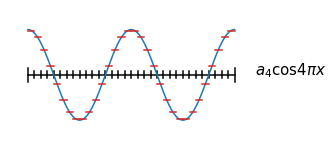

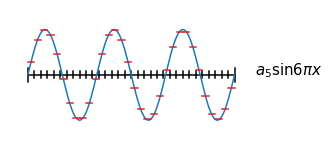

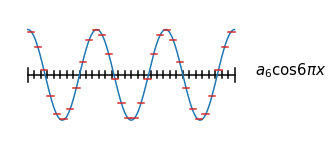

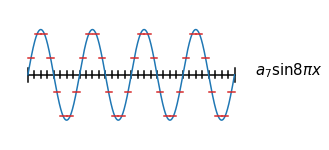

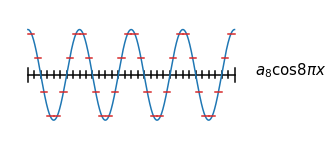

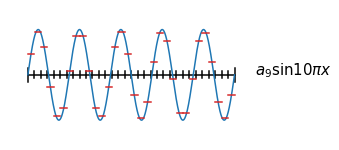

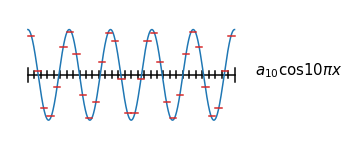

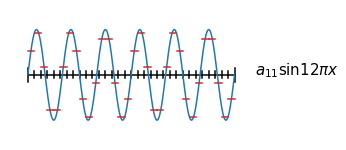

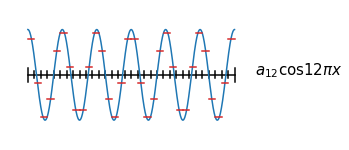

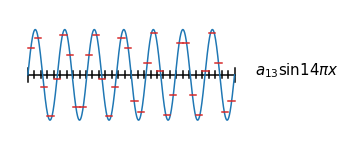

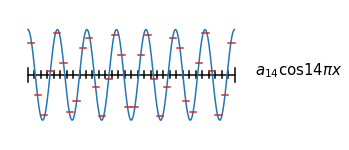

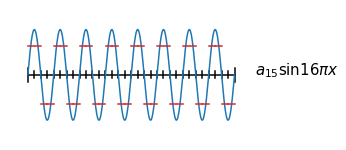

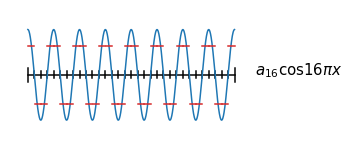

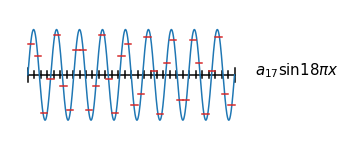

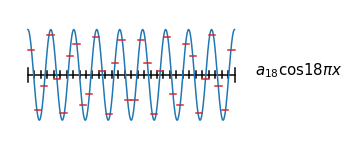

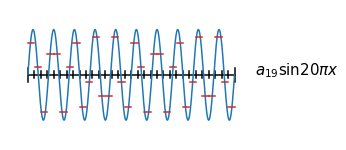

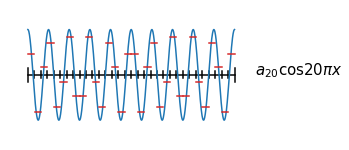

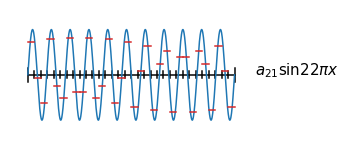

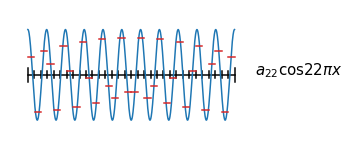

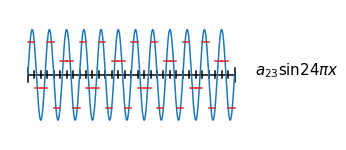

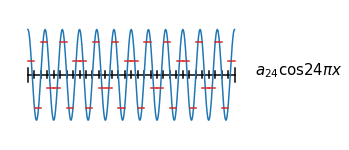

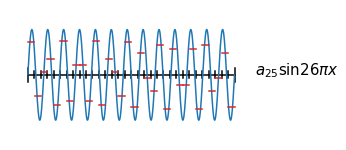

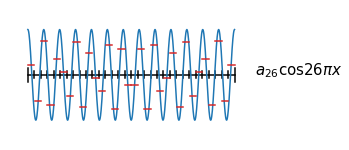

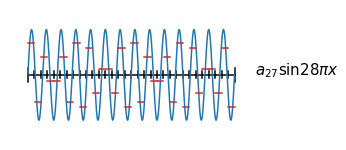

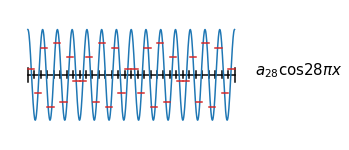

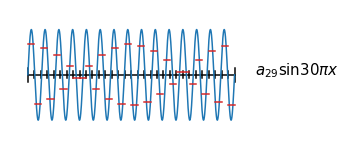

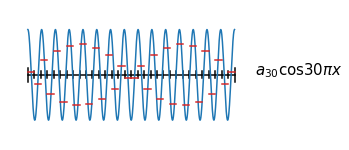

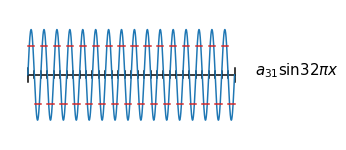

end loop i =  15




In [6]:
Residuals(omegaF, plot = False)

In [7]:
nullspace = np.zeros((4, 3), float)
np.fill_diagonal(nullspace, 1)
print(nullspace)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]
